## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [59]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
import re
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage   
from pydantic.v1 import BaseModel, Field, schema_json_of
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [60]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [61]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


In [62]:
# ==============================================================================
# CELL 1.5: KHỞI TẠO VÀ QUẢN LÝ TRÍ NHỚ DÀI HẠN (NÂNG CẤP V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# Hàm để tải trí nhớ từ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# Hàm để lưu một giáo án mới vào trí nhớ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.")

# Hàm để tạo một vector store từ trí nhớ (để tìm kiếm tương đồng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Trí nhớ trống, không có gì để xây dựng vector store.")
        return

    # Chỉ lấy phần 'request' để tìm kiếm
    texts = [item['request'] for item in memory_content]
    # Lưu toàn bộ item làm metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.")

# Tự động xây dựng vector store khi khởi động notebook
build_memory_vector_store()

⚠️  Trí nhớ trống, không có gì để xây dựng vector store.

## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [63]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [64]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị

print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [65]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [66]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH & CẤU TRÚC DỮ LIỆU (v9.7 - TƯ DUY LINH HOẠT)
# ==============================================================================
import json
from pydantic.v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- Các hàm tiện ích giữ nguyên ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === CẬP NHẬT CẤU TRÚC HOẠT ĐỘNG LINH HOẠT ===
class DifferentiatedInstructionModel(BaseModel):
    for_struggling_students: str = Field(description="Gợi ý cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Gợi ý, thử thách hoặc hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập.")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'description' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Mô tả phần hoạt động CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Mô tả phần hoạt động MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'question' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Nội dung câu hỏi hoặc đề bài CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Câu hỏi phụ hoặc thử thách MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn cho phần CỐT LÕI.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

# --- Các model khác giữ nguyên ---
class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")
    suggested_duration: Optional[int] = Field(default=None, description="Nếu có lỗi về thời gian, hãy đề xuất một thời lượng hợp lý hơn (tính bằng SỐ PHÚT).")

class Domain(BaseModel): domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")
class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]
class BlueprintStage(BaseModel): stage_name: str; stage_objective: str; stage_direction: str
class PedagogicalBlueprint(BaseModel): blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.


In [67]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
# === SỬA LỖI PARSING: Prompt được làm rõ ràng hơn về cấu trúc lồng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [68]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **VÍ DỤ THAM KHẢO (TỪ MỘT GIÁO ÁN THÀNH CÔNG TRƯỚC ĐÂY):**
        Đây là một luồng hoạt động đã được chứng minh là hiệu quả cho một chủ đề tương tự. Hãy học hỏi cấu trúc và cách tiếp cận từ nó:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    
    {example_prompt_part}
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...")
    
    if not memory_vector_store:
        print_warning("Không có Trí nhớ Dài hạn. Bỏ qua bước này.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # Tìm kiếm 1 ví dụ tương đồng nhất trong trí nhớ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Chỉ lấy nếu độ tương đồng cao (điểm score thấp là tốt)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "Tìm thấy ví dụ tương đồng trong trí nhớ")
            # Chỉ trả về phần "lesson_flow" để làm ví dụ
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Không tìm thấy ví dụ nào đủ tương đồng trong trí nhớ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"Lỗi khi truy xuất trí nhớ: {e}")
        return {"inspirational_example": None}
    
print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [69]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia tổng hợp thông tin.
    **NHIỆM VỤ DUY NHẤT:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **CHỈ DÙNG THÔNG TIN ĐƯỢC CUNG CẤP:** Tuyệt đối không được bình luận về chất lượng của các đoạn văn bản. Không được "từ chối" tóm tắt.
    2.  **TỔNG HỢP & SUY LUẬN:** Nhiệm vụ của bạn là đọc tất cả các mẩu thông tin (kể cả từ các bài tập) và suy luận ra các định nghĩa, tính chất cốt lõi nhất.
    3.  **CẤU TRÚC RÕ RÀNG:** Trình bày bản tóm tắt một cách mạch lạc, có đầu mục rõ ràng (ví dụ: 1. Định nghĩa, 2. Tính chất...).
    4.  **TRẢ VỀ TÓM TẮT:** Luôn luôn trả về một bản tóm tắt, ngay cả khi nó ngắn gọn do thông tin hạn chế.

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    {best_snippets_text}
    """
    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [70]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC & CHUYÊN MÔN (v9.9 - THIẾT QUÂN LUẬT)
# ==============================================================================

# === NÂNG CẤP LỚN: Plan Delegator với "Kinh nghiệm Sư phạm" ===
async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v9.9 - Nhà hoạch định Thực tế) đang triển khai...")
    
    blueprint = state.get('pedagogical_blueprint', [])
    topic = state.get('analyzed_objective', {}).get('topic', 'chủ đề đã cho')
    total_duration = state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)

    # Xóa các kết quả cũ từ lần chạy trước để bắt đầu lại sạch sẽ
    agent_outputs_history = state.get("agent_outputs", {})
    new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
        
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Nhà Hoạch định Sư phạm giàu kinh nghiệm.
    **NHIỆM VỤ:** Chuyển đổi "Bản thiết kế Sư phạm" cấp cao thành một danh sách các nhiệm vụ cụ thể, với sự phân bổ thời gian THỰC TẾ và KHẢ THI.

    **BẢN THIẾT KẾ SƯ PHẠM:**
    {json.dumps(blueprint, ensure_ascii=False, indent=2)}

    **BẢNG TRA CỨU KINH NGHIỆM SƯ PHẠM (THAM KHẢO BẮT BUỘC):**
    - **Khởi động/Khám phá ban đầu:** Thường mất 10-15 phút. Không nên quá ngắn.
    - **Xây dựng kiến thức mới/Giảng lý thuyết:** Mỗi khái niệm lớn cần 15-20 phút.
    - **Thực hành vẽ hình/Thí nghiệm (Học tập hợp tác):** Đây là hoạt động tốn thời gian nhất, thường cần 25-35 phút để đảm bảo chất lượng.
    - **Luyện tập/Củng cố:** Khoảng 15-25 phút.
    - **Tổng kết/Giao bài tập:** 5-10 phút.

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **TƯ DUY THỰC TẾ:** Dựa vào Bảng tra cứu kinh nghiệm, hãy phân bổ thời gian cho từng nhiệm vụ một cách hợp lý. ĐỪNG cố gắng nhồi nhét quá nhiều thứ vào một khoảng thời gian ngắn.
    2.  **TỔNG THỜI GIAN:** Tổng thời lượng của tất cả các nhiệm vụ cộng lại PHẢI bằng chính xác **{total_duration} phút**.
    3.  **HOẠT ĐỘNG ĐỆM:** Nhiệm vụ cuối cùng PHẢI là một hoạt động 'Vận dụng' hoặc 'Tổng kết' và có mô tả linh hoạt.

    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON tuân thủ schema `TaskListWithDuration`.
    """
    
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        
        # Kiểm tra lại tổng thời gian lần cuối
        current_total = sum(t['estimated_duration'] for t in tasks_with_status)
        if not (total_duration - 5 <= current_total <= total_duration + 5):
             print_warning(f"Plan Delegator đã tạo kế hoạch có tổng thời gian ({current_total}) không khớp với yêu cầu ({total_duration}). Vẫn tiếp tục nhưng có thể gây lỗi sau này.")

        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết")
        
        # Reset lại state để bắt đầu vòng thực thi mới
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    
    except Exception as e:
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        fallback_task = { "task_id": 0, "task_name": "Hoạt động luyện tập", "task_description": "Học sinh thực hành bài tập.", "estimated_duration": 45, "status": "pending" }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}


# --- CÁC HÀM CŨ GIỮ NGUYÊN ---
# (Dán lại các hàm content_validator_agent và specialist_agent_logic... từ lần trước vào đây)
async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step(f"`Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...")
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error"):
        return {"validation_feedback": "Lỗi tạo nội dung, không thể phản biện.", "current_content_to_validate": content}

    total_allowed_duration = state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)
    agent_outputs = state.get('agent_outputs', {})
    completed_activities = agent_outputs.get('activities', []) + agent_outputs.get('assessments', [])
    time_spent = sum(item.get('duration_minutes', 0) for item in completed_activities)
    time_remaining = total_allowed_duration - time_spent
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Cố vấn Sư phạm, chuyên gia về phân bổ thời gian và chất lượng nội dung.
    **NGÂN SÁCH THỜI GIAN HIỆN TẠI:**
    - Tổng thời lượng buổi học: {total_allowed_duration} phút.
    - Thời gian đã sử dụng cho các hoạt động trước: {time_spent} phút.
    - **Thời gian còn lại cho TẤT CẢ các hoạt động sau:** {time_remaining} phút.
    **NHIỆM VỤ:** Thẩm định nội dung được tạo ra, đặc biệt chú ý đến sự cân bằng giữa chất lượng và ngân sách thời gian.
    **YÊU CẦU GỐC CỦA NHIỆM VỤ:**
    - Tên nhiệm vụ: "{current_task.get('task_name', 'N/A')}"
    - Thời lượng dự kiến: "{current_task.get('estimated_duration', 'N/A')} phút"
    **NỘI DUNG ĐƯỢC TẠO RA CẦN XEM XÉT:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```
    **CÁC BƯỚC SUY LUẬN:**
    1.  **Kiểm tra Chất lượng:** Nội dung có chính xác về chuyên môn và phù hợp sư phạm không? Nếu không, `is_valid: false`.
    2.  **Kiểm tra Thời gian Nội tại:** Thời lượng `duration_minutes` trong nội dung có hợp lý với các thành phần `core_component` và `extension_component` không?
    3.  **Kiểm tra Ngân sách Toàn cục (QUAN TRỌNG NHẤT):** So sánh `duration_minutes` với `Thời gian còn lại`.
        - Nếu `duration_minutes` chiếm một phần hợp lý của thời gian còn lại (để vẫn còn đủ cho các hoạt động sau), thì nội dung hợp lệ.
        - Nếu `duration_minutes` quá lớn, chiếm gần hết hoặc vượt quá thời gian còn lại, đây là LỖI CẤU TRÚC NGHIÊM TRỌNG.
    **YÊU CẦU ĐỊNH DẠNG:**
    - Nếu hoàn toàn hợp lệ: `is_valid: true`, `feedback: "Nội dung hợp lệ."`.
    - Nếu có lỗi nhỏ về thời gian (có thể sửa): `is_valid: false`, `feedback: "[STRUCTURAL_FEEDBACK] Thời gian chưa tối ưu..."`, và **BẮT BUỘC** có `suggested_duration`.
    - Nếu có lỗi lớn về ngân sách thời gian: `is_valid: false`, `feedback: "[STRUCTURAL_FEEDBACK] Lỗi phân bổ ngân sách! Thời gian đề xuất ({content.get('duration_minutes')} phút) quá lớn so với thời gian còn lại ({time_remaining} phút). Cần thiết kế lại hoạt động này trong khoảng [X] phút để đảm bảo tiến độ."`, và **BẮT BUỘC** có `suggested_duration` là một con số hợp lý hơn.
    """
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        if result.is_valid:
            print_step("✔️ CỐ VẤN: Nội dung và ngân sách thời gian hợp lệ!")
            return {"validation_feedback": None, "current_content_to_validate": content}
        else:
            final_feedback = result.feedback
            if result.suggested_duration:
                final_feedback += f" | SUGGESTED_DURATION: {result.suggested_duration}"
            print_warning(f"CỐ VẤN PHẢN BIỆN: {final_feedback}")
            return {"validation_feedback": final_feedback, "current_content_to_validate": content}
    except Exception as e:
        print_warning(f"Lỗi tại Time-Budget Advisor: {e}. Mặc định cho qua.")
        return {"validation_feedback": None, "current_content_to_validate": content}

async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}}
    feedback_prompt = f"**PHẢN HỒI TỪ LẦN TRƯỚC (CẦN SỬA):** \"{state.get('validation_feedback', '')}\"." if state.get('validation_feedback') else ""
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập sáng tạo và thực tế.
    **NHIỆM VỤ:** Tạo ra **MỘT HOẠT ĐỘNG DUY NHẤT** với cấu trúc linh hoạt.
    **BỐI CẢNH BÀI HỌC:**
    - **Chủ đề chính:** {state.get('analyzed_objective', {}).get('topic', '')}
    - **Chiến lược phân hóa chung:** {state.get('student_persona', {}).get('differentiation_strategy', {})}
    **MÔ TẢ NHIỆM VỤ CẦN THỰC THI:**
    - **Tên nhiệm vụ:** "{task_to_run.get('task_name', '')}"
    - **Mô tả chi tiết:** "{task_to_run.get('task_description', '')}"
    - **THỜI GIAN ƯỚC TÍNH (RÀNG BUỘC CHÍNH):** {task_to_run.get('estimated_duration', 10)} phút.
    {feedback_prompt}
    **QUY TẮC TUYỆT ĐỐI:**
    1.  **ƯU TIÊN THỜI GIAN:** Tổng thời gian `duration_minutes` phải thực tế và tuân thủ thời gian ước tính.
    2.  **CẤU TRÚC LÕI/MỞ RỘNG:**
        -   **`core_component` (BẮT BUỘC):** Thiết kế phần hoạt động cốt lõi mà tất cả học sinh phải hoàn thành. Phần này nên chiếm khoảng 70-80% tổng thời gian.
        -   **`extension_component` (NẾU PHÙ HỢP):** Thiết kế một hoạt động nhỏ, bài tập thêm, hoặc câu hỏi mở rộng. Phần này là "nếu còn thời gian". Nếu hoạt động quá ngắn hoặc là hoạt động giới thiệu, trường này có thể bỏ trống.
    3.  **TẠO NỘI DUNG CỤ THỂ:** Đưa ra câu hỏi, đề bài rõ ràng trong các thành phần.
    4.  **TUÂN THỦ SCHEMA:** Chỉ trả về một đối tượng JSON duy nhất theo đúng cấu trúc.
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        content_dict['duration_minutes'] = task_to_run.get('estimated_duration', 10)
        content_dict['question_or_description'] = f"**Phần Cốt lõi:**\n{content_dict.get('core_component', '')}\n\n**Phần Mở rộng (nếu còn thời gian):**\n{content_dict.get('extension_component', 'Không có')}"
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra (Linh hoạt)")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}. Trả về nội dung mặc định.")
        return {"current_content_to_validate": {"error": str(e)}, "validation_feedback": None}

async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn (v9.9 - Thiết quân luật) đã sẵn sàng.")

✅ Các agent giao việc và chuyên môn (v9.9 - Thiết quân luật) đã sẵn sàng.


In [71]:
# ==============================================================================
# CELL 3.6: AGENT TỔNG HỢP & NODE TRÌNH BÀY (v9.7 - TƯ DUY LINH HOẠT)
# ==============================================================================

async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v9.7 - Tư duy Linh hoạt) đang tổng hợp giáo án...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    if not all_content_items:
        reflection = "Kế hoạch thất bại. Không có hoạt động nào được tạo ra. Lập kế hoạch lại."
        print_warning(f"CRITIC LỚN: {reflection}")
        return {"reflection_notes": reflection}

    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    
    # Nếu tổng thời gian hợp lệ, cho qua ngay
    if (allowed_duration * 0.95) <= total_duration <= (allowed_duration + 5):
         print_step(f"CRITIC LỚN: Kế hoạch hợp lệ! Tổng thời gian ({total_duration} phút) nằm trong giới hạn cho phép.")
    # Nếu không, thử "cắt tỉa" hoạt động cuối
    else:
        print_warning(f"CRITIC LỚN: Tổng thời gian ({total_duration} phút) không hợp lệ. Đang thử cắt tỉa hoạt động cuối...")
        
        all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))
        last_activity = all_content_sorted[-1]
        
        # Chỉ điều chỉnh nếu hoạt động cuối là hoạt động có thể co giãn
        is_flexible = "vận dụng" in last_activity.get('activity_name', '').lower() or \
                      "luyện tập" in last_activity.get('activity_name', '').lower() or \
                      last_activity.get('extension_component')

        if is_flexible:
            duration_of_last_activity = last_activity.get('duration_minutes', 0)
            duration_of_other_activities = total_duration - duration_of_last_activity
            
            new_duration_for_last = allowed_duration - duration_of_other_activities
            
            if new_duration_for_last >= 5: # Đảm bảo hoạt động cuối không quá ngắn
                print_step(f"Điều chỉnh thành công! Cắt bớt hoạt động cuối từ {duration_of_last_activity} phút xuống còn {new_duration_for_last} phút.")
                last_activity['duration_minutes'] = new_duration_for_last
                # Cập nhật lại mô tả để phản ánh việc cắt bớt
                last_activity['question_or_description'] = f"**Phần Cốt lõi:**\n{last_activity.get('core_component', '')}\n\n**Phần Mở rộng:** (Phần này có thể được bỏ qua do hạn chế về thời gian)"
                # Cập nhật lại danh sách với hoạt động đã được sửa
                all_content_items = all_content_sorted[:-1] + [last_activity]
            else:
                reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) quá dài, không thể cứu vãn. Lập kế hoạch lại từ đầu với thời gian ngắn hơn cho mỗi hoạt động."
                print_warning(f"CRITIC LỚN: {reflection}")
                return {"reflection_notes": reflection}
        else:
            reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ và hoạt động cuối không phải hoạt động linh hoạt. Lập kế hoạch lại."
            print_warning(f"CRITIC LỚN: {reflection}")
            return {"reflection_notes": reflection}

    # --- Phần còn lại giữ nguyên ---
    print_step("Bắt đầu tổng hợp giáo án dạng JSON...")
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]

    general_info = { "chủ đề": objective.get('topic', 'N/A'), "môn học": state.get('domain', 'N/A'), "lớp": objective.get('grade_level', 'N/A'), "thời lượng": f"{allowed_duration} phút", "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'), "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'), }
    learning_objectives = [ f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.", "Rèn luyện kỹ năng tư duy logic và giải quyết vấn đề.", "Phát triển kỹ năng hợp tác và trình bày." ]
    preparation = { "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập"], "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"] }
    final_plan_obj: FinalStructuredPlan = { "general_info": general_info, "learning_objectives": learning_objectives, "preparation": preparation, "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'), "lesson_flow": all_content_sorted, }

    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

# --- markdown_presentation_node giữ nguyên ---
def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v9.7) đang tạo bản trình bày Markdown...")
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict): return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án."}

    md_parts = []
    info = plan_json.get('general_info', {})
    md_parts.append(f"# GIÁO ÁN BÀI DẠY: {info.get('chủ đề', 'N/A').upper()}")
    md_parts.append("---")
    md_parts.append("## I. THÔNG TIN CHUNG")
    for key, value in info.items(): md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    md_parts.append("## II. MỤC TIÊU BÀI HỌC")
    for obj in plan_json.get('learning_objectives', []): md_parts.append(f"- {obj}")
    md_parts.append("## III. CHUẨN BỊ")
    for key, items in plan_json.get('preparation', {}).items(): md_parts.append(f"- **{key.title()}:** {', '.join(items)}")
    md_parts.append("## IV. TIẾN TRÌNH BÀI DẠY")
    for i, activity in enumerate(plan_json.get('lesson_flow', [])):
        md_parts.append(f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)")
        md_parts.append(f"**Nhiệm vụ:**\n{activity.get('question_or_description', 'Không có mô tả.')}")
        if activity.get('differentiation'):
            diff = activity['differentiation']
            md_parts.append(f"> **Gợi ý Phân hóa:**")
            md_parts.append(f"> - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students', 'Không có')}")
            md_parts.append(f"> - *Thử thách (HS giỏi):* {diff.get('for_advanced_students', 'Không có')}")
        md_parts.append("\n---")
    md_parts.append("## V. TÓM TẮT KIẾN THỨC CỐT LÕI")
    md_parts.append(plan_json.get('knowledge_summary', 'Chưa có tóm tắt.'))
    final_md = "\n".join(md_parts)
    return {"final_markdown_plan": final_md}

print("✅ Agent tổng hợp & Node trình bày (v9.7 - Tư duy Linh hoạt) đã sẵn sàng.")

✅ Agent tổng hợp & Node trình bày (v9.7 - Tư duy Linh hoạt) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [72]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH & ĐIỀU PHỐI (v9.9 - THIẾT QUÂN LUẬT)
# ==============================================================================
from typing import Literal, Dict, Any
import time
import re

# === NÂNG CẤP LỚN: "Bác sĩ phẫu thuật" thành "Người cân bằng Ngân sách" ===
def budget_balancing_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Node: Budget Balancer` đang phẫu thuật và cân bằng lại ngân sách...")
    feedback = state.get("validation_feedback")
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")

    if not all([feedback, task_list, current_task_id is not None]):
        return {}

    match = re.search(r"SUGGESTED_DURATION:\s*(\d+)", feedback)
    if not match:
        # Nếu không có gợi ý thời gian, có thể là lỗi chuyên môn, không xử lý ở đây
        return {"validation_feedback": "Phản hồi không chứa gợi ý thời gian.", "reflection_notes": feedback}
    
    suggested_duration = int(match.group(1))
    new_task_list = [t.copy() for t in task_list]
    
    # Tìm nhiệm vụ hiện tại và nhiệm vụ cuối cùng (đệm)
    current_task_index = -1
    last_flexible_task_index = -1
    
    for i, task in enumerate(new_task_list):
        if task.get("task_id") == current_task_id:
            current_task_index = i
        if "vận dụng" in task.get('task_name', '').lower() or "củng cố" in task.get('task_name', '').lower():
            last_flexible_task_index = i

    if current_task_index == -1:
        print_warning(f"Không tìm thấy task ID {current_task_id} để cập nhật.")
        return {}

    # Tính toán sự thay đổi thời gian
    original_duration = new_task_list[current_task_index].get('estimated_duration', 0)
    time_delta = suggested_duration - original_duration

    # Cập nhật nhiệm vụ hiện tại
    new_task_list[current_task_index]["estimated_duration"] = suggested_duration
    print_result({"task_id": current_task_id, "from": original_duration, "to": suggested_duration, "delta": time_delta}, "Bước 1: Cập nhật nhiệm vụ bị lỗi")

    # Cân bằng lại ngân sách bằng cách điều chỉnh nhiệm vụ đệm
    if time_delta != 0 and last_flexible_task_index != -1 and current_task_index != last_flexible_task_index:
        original_buffer_duration = new_task_list[last_flexible_task_index].get('estimated_duration', 0)
        new_buffer_duration = original_buffer_duration - time_delta
        
        # Đảm bảo hoạt động đệm không bị âm thời gian
        if new_buffer_duration < 5:
            new_buffer_duration = 5 # Thời gian tối thiểu
            print_warning("Không thể cân bằng hoàn toàn, hoạt động đệm đã ở mức tối thiểu.")
        
        new_task_list[last_flexible_task_index]['estimated_duration'] = new_buffer_duration
        print_result({"task_id": new_task_list[last_flexible_task_index]['task_id'], "from": original_buffer_duration, "to": new_buffer_duration}, "Bước 2: Cân bằng lại ngân sách ở hoạt động đệm")
    
    # Xóa feedback để chuẩn bị cho lần thử lại
    return {"task_list": new_task_list, "validation_feedback": None, "reflection_notes": None}


# --- CÁC NODE CŨ ---
def delay_node(state: "TeacherStateV5") -> "TeacherStateV5":
    time.sleep(1)
    return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Task Dispatcher` đang giao việc...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run: return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent sau: 'activity_designer', 'theory_synthesizer', 'assessment_creator'.\n\n**QUY TẮC PHÂN LOẠI:**\n- Giảng giải, giới thiệu, ôn tập, tổng kết -> 'theory_synthesizer'.\n- Luyện tập, thực hành, thảo luận, làm việc nhóm -> 'activity_designer'.\n- Kiểm tra, đánh giá, bài toán khó, vận dụng cao -> 'assessment_creator'.\n\n**NHIỆM VỤ CẦN PHÂN LOẠI:** \"{task_description}\"\n\n**YÊU CẦU JSON:** Trả về JSON với key duy nhất là `agent_category`."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception:
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    content['task_id'] = state['current_task_id']
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("✅ Các node tiện ích và điều phối (v9.9 - Thiết quân luật) đã sẵn sàng.")

✅ Các node tiện ích và điều phối (v9.9 - Thiết quân luật) đã sẵn sàng.


In [73]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN (ĐÃ SỬA LỖI)
# ==============================================================================
def route_after_validation(state: "TeacherStateV5") -> Literal["commit", "retry_content", "replan_task"]:
    """
    Hàm điều hướng mới, thông minh hơn sau khi thẩm định nội dung.
    - commit: Nội dung hợp lệ.
    - replan_task: Nội dung có lỗi cấu trúc/thời gian, cần quay lại bước lập kế hoạch.
    - retry_content: Nội dung có lỗi chuyên môn/sư phạm, cần agent chuyên môn thử lại.
    """
    feedback = state.get("validation_feedback")
    if feedback is None:
        print_step("ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.")
        return "commit"
    
    if "[STRUCTURAL_FEEDBACK]" in feedback:
        print_step("ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.")
        # Chuyển phản hồi này cho Plan Delegator
        state['reflection_notes'] = feedback
        return "replan_task"
    else:
        print_step("ROUTER (Validation): Nội dung bị từ chối. Quay lại để agent chuyên môn THỬ LẠI.")
        return "retry_content"

def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.")

✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.


In [74]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (v9.9.1 - SỬA LỖI KẾT NỐI)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# 1. Thêm tất cả các node
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("budget_balancer", budget_balancing_node) # Đổi tên từ update_task_duration
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("delay_node", delay_node)

# 2. Thiết lập các kết nối (edges) - PHIÊN BẢN ĐẦY ĐỦ
# Luồng Phân tích & Lập kế hoạch ban đầu (NỐI LẠI MẠCH)
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter") # <-- LỖI ĐÃ ĐƯỢC SỬA Ở ĐÂY
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# Luồng thực thi nhiệm vụ
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    {
        "continue_executing": "task_dispatcher",
        "compile_and_critique": "structured_plan_compiler"
    }
)

# Luồng thực thi chi tiết
workflow.add_conditional_edges("task_dispatcher", lambda state: state["next_agent"], {
    "activity_designer": "activity_designer", 
    "assessment_creator": "assessment_creator", 
    "theory_synthesizer": "theory_synthesizer"
})
workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")

# Luồng sửa chữa và cân bằng ngân sách
workflow.add_conditional_edges(
    "content_validator", 
    route_after_validation,
    {
        "commit": "commit_validated_content", 
        "retry_content": "task_dispatcher",
        "replan_task": "budget_balancer" 
    }
)
workflow.add_edge("budget_balancer", "task_dispatcher")

# Hoàn thành một nhiệm vụ
workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# Luồng kết thúc
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation,
    {
        "replan": "plan_delegator", 
        "finish": "markdown_presenter"
    }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Biên dịch graph
app = workflow.compile()
print("✅ Graph đã được biên dịch thành công với chuỗi kết nối hoàn chỉnh (v9.9.1).")

✅ Graph đã được biên dịch thành công với chuỗi kết nối hoàn chỉnh (v9.9.1).


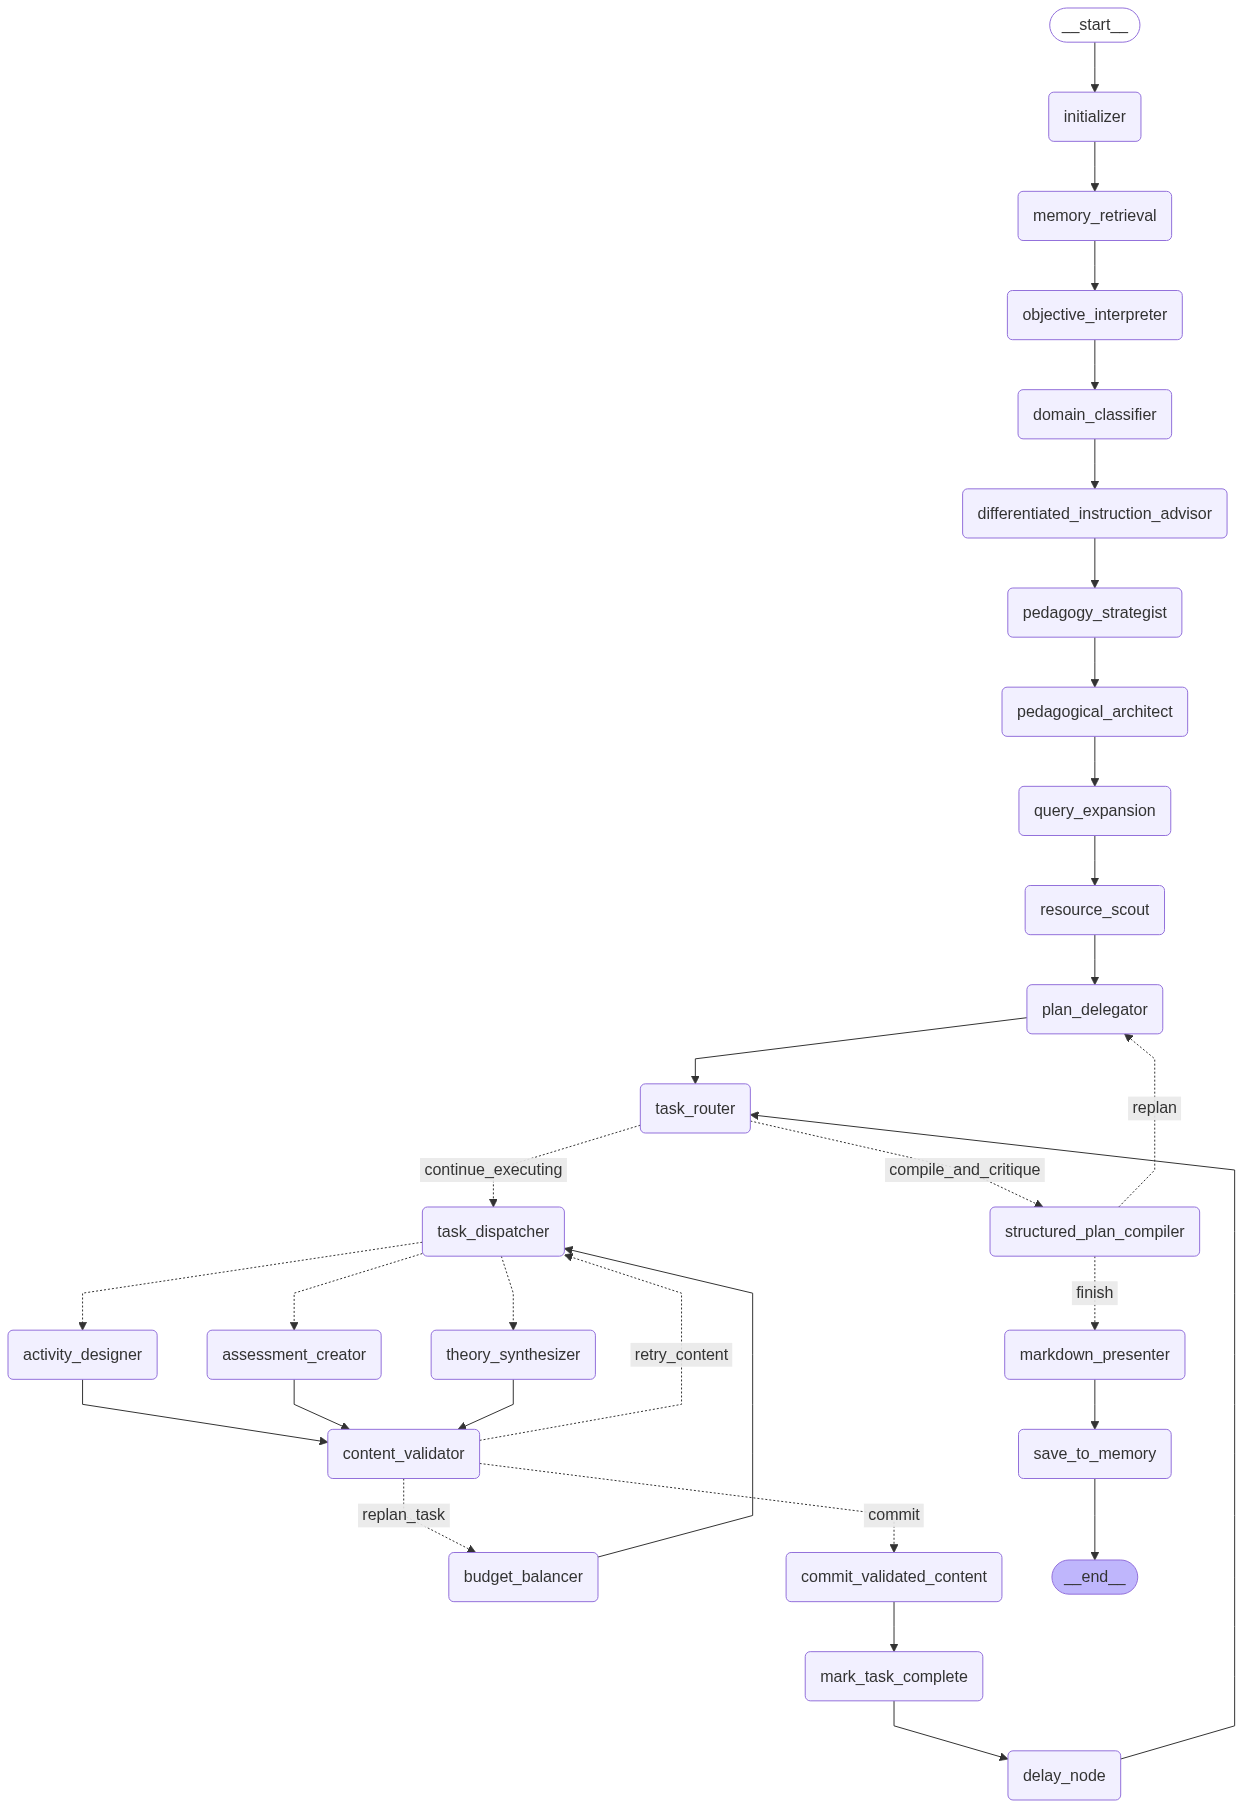

In [75]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [76]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo. Vui lòng chạy lại Cell 1.3.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải. Vui lòng chạy lại Cell 1.4.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch. Vui lòng chạy lại Cell 4.3.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_state_result = None
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                final_state_result = node_output

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH V7.1.[/bold magenta]")
        
        if final_state_result and final_state_result.get("final_markdown_plan"):
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v9.0)[/bold green]")
            console.print(Markdown(final_state_result["final_markdown_plan"]))
            
            # (Tùy chọn) In ra cả JSON để kiểm tra
            if VERBOSE_MODE:
                print_result(final_state_result.get("final_structured_plan"), "Output JSON có cấu trúc")

        else:
            print_warning("Không tạo được giáo án cuối cùng. Có thể Critic đã yêu cầu làm lại nhưng hết giới hạn đệ quy.")
            print("\nTrạng thái cuối cùng để gỡ lỗi:")
            pprint(final_state_result)
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` đã sẵn sàng để sử dụng.


In [ ]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...

⚠️  Không có Trí nhớ Dài hạn. Bỏ qua bước này.

------- Hoàn thành bước: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 2,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'Lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học khá yếu, học sinh dễ mất tập trung và cần các hoạt động tương tác cao để duy trì sự chú ý và hứng thú.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần nhỏ, sử dụng nhiều ví dụ minh họa trực quan, cung cấp phiếu bài tập có gợi ý chi tiết và bài tập cơ bản. Tổ chức các hoạt động nhóm nhỏ để học sinh yếu nhận được sự hỗ trợ từ bạn bè và giáo viên. Dành thời gian kiểm tra, củng cố kiến thức nền tảng thường xuyên.',
│   │   'for_advanced_students': 'Giao các bài tập nâng cao, đòi hỏi tư duy tổng hợp hoặc ứng dụng thực tế. Khuyến khích các em tìm nhiều cách giải khác nhau hoặc tự chứng minh một số tính chất. Có thể yêu cầu các em hỗ trợ, hướng dẫn các bạn yếu hơn trong nhóm hoặc chuẩn bị một câu hỏi mở rộng để thảo luận chung.'
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': 'Phương pháp dạy học hợp tác rất phù hợp với lớp học có tốc độ học chậm, học sinh thụ động và dễ mất tập trung. Nó tạo ra môi trường học tập năng động, khuyến khích sự tương tác liên tục giữa các thành viên, giúp học sinh chủ động hơn trong việc tiếp thu kiến thức. Học sinh yếu sẽ nhận được sự hỗ trợ trực tiếp từ bạn bè và giáo viên, trong khi học sinh khá giỏi có cơ hội củng cố kiến thức bằng cách giải thích cho người khác. Việc chia nhỏ kiến thức thành các nhiệm vụ nhóm cụ thể cũng giúp học sinh tiếp cận bài học một cách từ từ, hiệu quả và duy trì sự hứng thú trong suốt 90 phút.',
│   'key_actions': [
│   │   'Chia nhóm và giao nhiệm vụ học tập cụ thể liên quan đến đường tròn ngoại tiếp và nội tiếp.',
│   │   'Học sinh làm việc nhóm để nghiên cứu, thảo luận và giải quyết các nhiệm vụ được giao, với sự hỗ trợ của giáo viên.',
│   │   'Đại diện các nhóm trình bày sản phẩm hoặc kết quả làm việc của nhóm mình trước lớp.',
│   │   'Giáo viên tổng kết, hệ thống hóa kiến thức, giải đáp thắc mắc và củng cố các khái niệm trọng tâm.',
│   │   'Học sinh thực hành cá nhân thông qua các bài tập để củng cố kiến thức và giáo viên đánh giá mức độ tiếp thu.'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   'Khởi động và Khám phá ban đầu: Giáo viên tổ chức trò chơi hoặc câu đố nhanh liên quan đến các yếu tố của đường tròn và tam giác. Sử dụng hình ảnh trực quan (ví dụ: một vật thể hình tròn bao quanh một vật thể hình tam giác, hoặc ngược lại) để giới thiệu khái niệm "ngoại tiếp" và "nội tiếp" một cách trực quan, dễ hiểu. Chia lớp thành các nhóm nhỏ (4-5 học sinh).',
│   'Xây dựng kiến thức qua hoạt động nhóm: Mỗi nhóm nhận một phiếu học tập hoặc nhiệm vụ cụ thể (ví dụ: Nhóm A tìm hiểu về đường tròn ngoại tiếp, Nhóm B tìm hiểu về đường tròn nội tiếp). Nhiệm vụ bao gồm đọc tài liệu, vẽ hình, thảo luận để trả lời các câu hỏi gợi mở. Giáo viên di chuyển giữa các nhóm, quan sát, gợi ý và hỗ trợ khi cần thiết, đặc biệt chú ý đến các nhóm có học sinh yếu.',
│   'Trình bày, Chuẩn hóa và Củng cố: Đại diện các nhóm lên bảng trình bày sản phẩm của nhóm mình (có thể là sơ đồ tư duy, hình vẽ, hoặc tóm tắt các định nghĩa/tính chất). Giáo viên lắng nghe, nhận xét, bổ sung và điều chỉnh để đảm bảo kiến thức được chính xác và đầy đủ. Tổng kết các khái niệm trọng tâm, các tính chất quan trọng và cách xác định tâm/bán kính của hai loại đường tròn này.',
│   'Vận dụng và Luyện tập cá nhân/nhóm: Giáo viên phát phiếu bài tập với các dạng bài từ nhận biết, thông hiểu đến vận dụng. Học sinh làm bài tập cá nhân. Đối với học sinh yếu, giáo viên cung cấp phiếu bài tập có gợi ý chi tiết hoặc cho phép làm việc theo cặp/nhóm nhỏ để nhận sự hỗ trợ. Học sinh khá giỏi được khuyến khích làm các bài tập nâng cao hoặc tìm nhiều cách giải khác nhau. Giáo viên quan sát, hỗ trợ và chữa bài tập mẫu.',
│   'Tổng kết và Định hướng: Giáo viên cùng học sinh tóm tắt lại các kiến thức cốt lõi về đường tròn ngoại tiếp và nội tiếp. Tổ chức một hoạt động kiểm tra nhanh (ví dụ: "Ai nhanh hơn" với các câu hỏi trắc nghiệm ngắn) để đánh giá mức độ hiểu bài. Giao bài tập về nhà và gợi ý các nguồn tài liệu để học sinh tự tìm hiểu thêm hoặc chuẩn bị cho bài học tiếp theo.'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'Đường tròn ngoại tiếp là gì',
│   'Đường tròn nội tiếp là gì',
│   'Công thức tính bán kính đường tròn ngoại tiếp tam giác',
│   'Công thức tính bán kính đường tròn nội tiếp tam giác',
│   'Tính chất đường tròn ngoại tiếp và nội tiếp',
│   'Bài tập đường tròn ngoại tiếp và nội tiếp lớp 9',
│   'Chuyên đề đường tròn ngoại tiếp nội tiếp hình học',
│   'Cách xác định tâm đường tròn ngoại tiếp',
│   'Cách xác định tâm đường tròn nội tiếp',
│   'Đường tròn ngoại tiếp tam giác vuông cân',
│   'Đường tròn nội tiếp tam giác đều',
│   'Ứng dụng đường tròn ngoại tiếp nội tiếp trong giải toán',
│   'Lý thuyết đường tròn ngoại tiếp nội tiếp THCS',
│   'Các dạng bài tập đường tròn ngoại tiếp nội tiếp nâng cao',
│   'Mối quan hệ giữa đường tròn ngoại tiếp và nội tiếp tam giác'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 75 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào các em,\n\nVới vai trò là một giáo viên, thầy sẽ tổng hợp kiến thức cốt lõi dựa **chỉ** vào các đoạn văn bản mà các em đã cung cấp. Mặc dù chủ đề yêu cầu là "Đường tròn ngoại tiếp và đường tròn nội tiếp", nhưng các đoạn văn bản này tập trung vào các khái niệm cơ bản hơn về vị trí tương đối của đường thẳng và đường tròn, cũng như tiếp tuyến của đường tròn. Đây là những kiến thức nền tảng rất quan trọng để sau này chúng ta tìm hiểu sâu hơn về đường tròn ngoại tiếp và nội tiếp.\n\nDưới đây là bản tóm tắt kiến thức cốt lõi từ tài liệu đã cho:\n\n---\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI VỀ CHỦ ĐỀ "ĐƯỜNG TRÒN NGOẠI TIẾP VÀ ĐƯỜNG TRÒN NỘI TIẾP" (Dựa trên các đoạn văn bản đã cung cấp)**\n\n**1. Vị trí tương đối của đường thẳng và đường tròn**\n\n*   **Định nghĩa:**\n    *   **Cắt nhau:** Đường thẳng và đường tròn có đúng hai điểm chung.\n    *   **Tiếp xúc với nhau:** Đường thẳng và đường tròn có đúng một điểm chung. Điểm chung này được gọi là **tiếp điểm**. Khi đó, đường thẳng còn được gọi là **tiếp tuyến** của đường tròn tại tiếp điểm.\n    *   **Không giao nhau:** Đường thẳng và đường tròn không có điểm chung nào.\n\n*   **Mối liên hệ giữa khoảng cách từ tâm đến đường thẳng (d) và bán kính (R):**\n    *   Đường thẳng và đường tròn cắt nhau khi $d < R$.\n    *   Đường thẳng và đường tròn tiếp xúc với nhau khi $d = R$.\n    *   Đường thẳng và đường tròn không giao nhau khi $d > R$.\n\n**2. Dấu hiệu nhận biết tiếp tuyến của đường tròn**\n\n*   **Định lí 1:** Nếu một đường thẳng đi qua một điểm trên một đường tròn và vuông góc với bán kính đi qua điểm đó thì đường thẳng ấy là một tiếp tuyến của đường tròn.\n\n**3. Các tính chất và ứng dụng liên quan đến tiếp tuyến (từ các bài tập)**\n\n*   **Tính chất về các tiếp tuyến cắt nhau (Bài 5.30a):**\n    Cho đường tròn (O) đường kính AB, tiếp tuyến xx\' tại A và tiếp tuyến yy\' tại B của (O). Một tiếp tuyến thứ ba của (O) tại điểm P (P khác A và B) cắt xx\' tại M và cắt yy\' tại N. Khi đó, đoạn thẳng MN bằng tổng độ dài của MA và NB ($MN = MA + NB$).\n\n*   **Tính chất về tiếp tuyến chung và tiếp xúc ngoài (Bài 5.31a, 5.31b):**\n    Cho hai đường tròn (O) và (O\') tiếp xúc ngoài với nhau tại A và cùng tiếp xúc với một đường thẳng d tại B và C. Tiếp tuyến của (O) tại A cắt BC tại M. Khi đó:\n    *   Đường thẳng MA cũng tiếp xúc với đường tròn (O\').\n    *   Điểm M là trung điểm của đoạn thẳng BC.\n\n---\n\nHy vọng bản tóm tắt này giúp các em nắm vững các kiến thức cơ bản về đường tròn và tiếp tuyến từ tài liệu đã học.'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v9.9 - Nhà hoạch định Thực tế) đang triển khai...

✔️ Đã tạo 5 nhiệm vụ chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Khám phá ban đầu',
│   │   'task_description': 'Giáo viên tổ chức trò chơi hoặc câu đố nhanh liên quan đến các yếu tố của đường tròn và tam giác. Sử dụng hình ảnh trực quan (ví dụ: một vật thể hình tròn bao quanh một vật thể hình tam giác, hoặc ngược lại) để giới thiệu khái niệm "ngoại tiếp" và "nội tiếp" một cách trực quan, dễ hiểu. Chia lớp thành các nhóm nhỏ (4-5 học sinh).',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Xây dựng kiến thức qua hoạt động nhóm',
│   │   'task_description': 'Mỗi nhóm nhận một phiếu học tập hoặc nhiệm vụ cụ thể (ví dụ: Nhóm A tìm hiểu về đường tròn ngoại tiếp, Nhóm B tìm hiểu về đường tròn nội tiếp). Nhiệm vụ bao gồm đọc tài liệu, vẽ hình, thảo luận để trả lời các câu hỏi gợi mở. Giáo viên di chuyển giữa các nhóm, quan sát, gợi ý và hỗ trợ khi cần thiết, đặc biệt chú ý đến các nhóm có học sinh yếu.',
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Trình bày, Chuẩn hóa và Củng cố kiến thức',
│   │   'task_description': 'Đại diện các nhóm lên bảng trình bày sản phẩm của nhóm mình (có thể là sơ đồ tư duy, hình vẽ, hoặc tóm tắt các định nghĩa/tính chất). Giáo viên lắng nghe, nhận xét, bổ sung và điều chỉnh để đảm bảo kiến thức được chính xác và đầy đủ. Tổng kết các khái niệm trọng tâm, các tính chất quan trọng và cách xác định tâm/bán kính của hai loại đường tròn này.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Vận dụng và Luyện tập cá nhân/nhóm',
│   │   'task_description': 'Giáo viên phát phiếu bài tập với các dạng bài từ nhận biết, thông hiểu đến vận dụng. Học sinh làm bài tập cá nhân. Đối với học sinh yếu, giáo viên cung cấp phiếu bài tập có gợi ý chi tiết hoặc cho phép làm việc theo cặp/nhóm nhỏ để nhận sự hỗ trợ. Học sinh khá giỏi được khuyến khích làm các bài tập nâng cao hoặc tìm nhiều cách giải khác nhau. Giáo viên quan sát, hỗ trợ và chữa bài tập mẫu.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Tổng kết và Định hướng',
│   │   'task_description': 'Giáo viên cùng học sinh tóm tắt lại các kiến thức cốt lõi về đường tròn ngoại tiếp và nội tiếp. Tổ chức một hoạt động kiểm tra nhanh (ví dụ: "Ai nhanh hơn" với các câu hỏi trắc nghiệm ngắn) để đánh giá mức độ hiểu bài. Giao bài tập về nhà và gợi ý các nguồn tài liệu để học sinh tự tìm hiểu thêm hoặc chuẩn bị cho bài học tiếp theo.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Khám phá ban đầu' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Activity Designer tạo ra (Linh hoạt):

{
│   'activity_name': 'Khởi động và Khám phá ban đầu',
│   'activity_type': 'Trò chơi, Quan sát và Thảo luận nhóm',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh/vật thể trực quan (ví dụ: đĩa tròn đặt trên tam giác, hoặc tam giác vẽ trong đường tròn).',
│   │   'Tổ chức trò chơi "Ai nhanh hơn?" với các câu hỏi nhanh về định nghĩa đường tròn, tam giác, các yếu tố cơ bản (tâm, bán kính, cạnh, góc).',
│   │   'Chiếu/trình bày các hình ảnh trực quan và đặt câu hỏi gợi mở: "Các em thấy mối quan hệ giữa hình tròn và hình tam giác trong các hình này là gì?"',
│   │   'Chia lớp thành các nhóm nhỏ (4-5 học sinh) và hướng dẫn thảo luận.',
│   │   'Lắng nghe, quan sát các nhóm thảo luận, gợi ý khi cần thiết.',
│   │   'Tổng hợp ý kiến các nhóm và chính thức giới thiệu khái niệm "đường tròn ngoại tiếp" và "đường tròn nội tiếp" dựa trên các ví dụ đã quan sát.'
│   ],
│   'core_component': 'Phần 1: Khởi động nhanh (5 phút) Học sinh tham gia trò chơi "Ai nhanh hơn?" trả lời các câu hỏi trắc nghiệm hoặc điền từ về các khái niệm cơ bản của đường tròn và tam giác (ví dụ: \'Tâm của đường tròn là...\', \'Tam giác có 3 cạnh và 3...\'). Phần 2: Khám phá trực quan (8 phút) Giáo viên trình chiếu các hình ảnh/vật thể thực tế (ví dụ: một chiếc bánh pizza hình tròn đặt vừa vặn trong hộp hình tam giác, hoặc một chiếc nhẫn tròn đeo vừa ngón tay hình tam giác). Các nhóm thảo luận và trả lời các câu hỏi: 1. Mô tả mối quan hệ vị trí giữa hình tròn và hình tam giác trong mỗi hình ảnh. 2. Theo các em, khi nào thì một hình tròn được gọi là \'bao quanh\' một tam giác, và khi nào thì một tam giác được gọi là \'nằm trong\' một hình tròn? 3. Hãy thử dùng từ ngữ của riêng mình để diễn tả hai mối quan hệ này. Giáo viên tổng hợp ý kiến và giới thiệu chính thức thuật ngữ \'đường tròn ngoại tiếp\' và \'đường tròn nội tiếp\'.',
│   'extension_component': "Nếu còn thời gian, các nhóm suy nghĩ: 'Ngoài các hình ảnh đã xem, các em có thể nghĩ ra ví dụ nào khác trong đời sống thực tế thể hiện mối quan hệ ngoại tiếp hoặc nội tiếp không?'",
│   'solution_guide': "Các câu hỏi gợi mở cho giáo viên khi tổng kết: 'Đường tròn ngoại tiếp' là đường tròn đi qua những điểm nào của tam giác? 'Đường tròn nội tiếp' là đường tròn tiếp xúc với những yếu tố nào của tam giác? Làm thế nào để xác định tâm của đường tròn ngoại tiếp/nội tiếp một tam giác?",
│   'differentiation': {
│   │   'for_struggling_students': "Trong trò chơi khởi động, giáo viên có thể đặt các câu hỏi dễ hơn, có nhiều gợi ý. Khi quan sát hình ảnh, giáo viên có thể chỉ rõ từng chi tiết và đặt câu hỏi cụ thể hơn: 'Hình tròn này chạm vào những điểm nào của tam giác?', 'Hình tam giác này nằm hoàn toàn bên trong hay bên ngoài hình tròn?'. Khuyến khích các em vẽ lại các hình đơn giản.",
│   │   'for_advanced_students': "Khuyến khích các em tự đưa ra định nghĩa ban đầu cho 'ngoại tiếp' và 'nội tiếp' trước khi giáo viên giới thiệu. Yêu cầu các em suy nghĩ về các tính chất đặc biệt của tâm đường tròn ngoại tiếp/nội tiếp mà các em đã biết (ví dụ: tâm đường tròn ngoại tiếp là giao điểm của các đường trung trực). Thử thách các em tìm thêm các ví dụ phức tạp hơn trong thực tế."
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nPhần 1: Khởi động nhanh (5 phút) Học sinh tham gia trò chơi "Ai nhanh hơn?" trả lời các câu hỏi trắc nghiệm hoặc điền từ về các khái niệm cơ bản của đường tròn và tam giác (ví dụ: \'Tâm của đường tròn là...\', \'Tam giác có 3 cạnh và 3...\'). Phần 2: Khám phá trực quan (8 phút) Giáo viên trình chiếu các hình ảnh/vật thể thực tế (ví dụ: một chiếc bánh pizza hình tròn đặt vừa vặn trong hộp hình tam giác, hoặc một chiếc nhẫn tròn đeo vừa ngón tay hình tam giác). Các nhóm thảo luận và trả lời các câu hỏi: 1. Mô tả mối quan hệ vị trí giữa hình tròn và hình tam giác trong mỗi hình ảnh. 2. Theo các em, khi nào thì một hình tròn được gọi là \'bao quanh\' một tam giác, và khi nào thì một tam giác được gọi là \'nằm trong\' một hình tròn? 3. Hãy thử dùng từ ngữ của riêng mình để

------- Hoàn thành bước: activity_designer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời gian phân bổ cho phần Khám phá trực quan (8 phút) có thể hơi gấp 
gáp để học sinh có đủ thời gian thảo luận sâu và giáo viên tổng hợp, giới thiệu hai khái niệm mới một cách hiệu 
quả. Nên dành thêm thời gian cho hoạt động cốt lõi này để đảm bảo sự hiểu bài của học sinh. | SUGGESTED_DURATION: 
20

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Budget Balancer` đang phẫu thuật và cân bằng lại ngân sách...

✔️ Bước 1: Cập nhật nhiệm vụ bị lỗi:

{
│   'task_id': 0,
│   'from': 15,
│   'to': 20,
│   'delta': 5
}

✔️ Bước 2: Cân bằng lại ngân sách ở hoạt động đệm:

{
│   'task_id': 3,
│   'from': 15,
│   'to': 10
}

------- Hoàn thành bước: budget_balancer -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Activity Designer tạo ra (Linh hoạt):

{
│   'activity_name': 'Khởi động và Khám phá ban đầu',
│   'activity_type': 'Trò chơi tương tác và Thảo luận nhóm',
│   'duration_minutes': 20,
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh trực quan (vật thể thật hoặc hình ảnh trình chiếu) về đường tròn và tam giác có mối quan hệ ngoại tiếp/nội tiếp.',
│   │   'Tổ chức lớp thành các nhóm nhỏ (4-5 học sinh).',
│   │   'Phát phiếu bài tập hoặc bảng nhóm cho các nhóm.',
│   │   'Đặt câu hỏi gợi mở và khuyến khích học sinh thảo luận trong nhóm.',
│   │   'Lắng nghe các câu trả lời của học sinh, ghi nhận các ý tưởng hay.',
│   │   "Giới thiệu chính xác khái niệm 'đường tròn ngoại tiếp' và 'đường tròn nội tiếp' sau khi học sinh đã có những nhận định ban đầu.",
│   │   'Hướng dẫn học sinh vẽ ví dụ đơn giản về hai loại đường tròn này.',
│   │   'Đi vòng quanh các nhóm để quan sát, hỗ trợ và giải đáp thắc mắc.'
│   ],
│   'core_component': "Giáo viên trình chiếu các hình ảnh trực quan (ví dụ: một chiếc đĩa tròn đặt trên một miếng bánh hình tam giác, hoặc một chiếc nhẫn tròn lồng vào một mặt dây chuyền hình tam giác). Học sinh theo nhóm (4-5 em) sẽ quan sát và thảo luận nhanh trong 5 phút để trả lời các câu hỏi: 1. Vật thể nào nằm 'bên trong' vật thể nào? 2. Vật thể nào 'bao quanh' vật thể nào? 3. Hãy dùng từ ngữ của riêng em để mô tả mối quan hệ giữa hai vật thể này. Sau đó, giáo viên giới thiệu chính xác các thuật ngữ 'đường tròn ngoại tiếp' và 'đường tròn nội tiếp' thông qua các hình ảnh đã cho và các ví dụ đơn giản khác trên bảng/máy chiếu. Các nhóm sẽ cùng nhau vẽ nhanh một ví dụ về đường tròn ngoại tiếp tam giác và một ví dụ về đường tròn nội tiếp tam giác vào phiếu bài tập hoặc bảng nhóm.",
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể thử thách nhau bằng cách vẽ một hình tam giác bất kỳ và cố gắng vẽ phác thảo đường tròn ngoại tiếp hoặc nội tiếp của tam giác đó mà không cần dụng cụ, chỉ dựa trên cảm nhận ban đầu về vị trí tâm và bán kính. Sau đó, các nhóm chia sẻ hình vẽ của mình và nhận xét lẫn nhau.',
│   'solution_guide': "Các câu trả lời mong đợi từ học sinh: 1. Vật thể này nằm trong vật thể kia. 2. Vật thể này bao quanh vật thể kia. 3. Mối quan hệ 'bao bọc' hoặc 'nằm gọn trong'. Giáo viên cần chốt lại rằng 'đường tròn ngoại tiếp' là đường tròn đi qua tất cả các đỉnh của tam giác, còn 'đường tròn nội tiếp' là đường tròn tiếp xúc với tất cả các cạnh của tam giác.",
│   'differentiation': {
│   │   'for_struggling_students': "Giáo viên cung cấp thêm các hình ảnh minh họa rõ ràng hơn, có thể là các mô hình vật lý để học sinh dễ hình dung. Gợi ý các từ khóa đơn giản như 'nằm ngoài', 'nằm trong', 'chạm vào' để các em dễ mô tả. Đảm bảo các em hiểu được khái niệm cơ bản trước khi chuyển sang phần vẽ.",
│   │   'for_advanced_students': "Yêu cầu các em suy nghĩ và đưa ra thêm các ví dụ khác trong thực tế về mối quan hệ ngoại tiếp/nội tiếp. Có thể đặt câu hỏi mở rộng: 'Theo em, có phải lúc nào một tam giác cũng có đường tròn ngoại tiếp và đường tròn nội tiếp không? Vì sao?' hoặc 'Có mối quan hệ tương tự nào giữa hình tròn và các hình đa giác khác không?'"
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nGiáo viên trình chiếu các hình ảnh trực quan (ví dụ: một chiếc đĩa tròn đặt trên một miếng bánh hình tam giác, hoặc một chiếc nhẫn tròn lồng vào một mặt dây chuyền hình tam giác). Học sinh theo nhóm (4-5 em) sẽ quan sát và thảo luận nhanh trong 5 phút để trả lời các câu hỏi: 1. Vật thể nào nằm 'bên trong' vật thể nào? 2. Vật thể nào 'bao quanh' vật thể nào? 3. Hãy dùng từ ngữ của riêng em để mô tả mối quan hệ giữa hai vật thể này. Sau đó, giáo viên giới thiệu chính xác các thuật ngữ 'đường tròn ngoại tiếp' và 'đường tròn nội tiếp' thông qua các hình ảnh đã cho và các ví dụ đơn giản khác trên bảng/máy chiếu. Các nhóm sẽ cùng nhau vẽ nhanh một ví dụ về đường tròn ngoại tiếp tam giác và một ví dụ về đường tròn nội tiếp tam giác vào phiếu bài tập hoặc bảng nhóm.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, các nhóm có thể thử thách nhau

------- Hoàn thành bước: activity_designer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

> ✔️ CỐ VẤN: Nội dung và ngân sách thời gian hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Xây dựng kiến thức qua hoạt động nhóm' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Activity Designer tạo ra (Linh hoạt):

{
│   'activity_name': 'Xây dựng kiến thức qua hoạt động nhóm',
│   'activity_type': 'Hoạt động nhóm',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Phát phiếu học tập/nhiệm vụ cho từng nhóm (Nhóm A: Đường tròn ngoại tiếp; Nhóm B: Đường tròn nội tiếp).',
│   │   'Quan sát, lắng nghe các nhóm thảo luận và kịp thời đưa ra gợi ý, định hướng khi cần thiết.',
│   │   'Di chuyển linh hoạt giữa các nhóm, đặc biệt ưu tiên hỗ trợ các nhóm có học sinh yếu bằng cách đặt câu hỏi gợi mở, kiểm tra kiến thức nền tảng.',
│   │   'Đảm bảo các nhóm đều nắm được nhiệm vụ và tiến độ làm việc.',
│   │   'Chuẩn bị cho phần báo cáo/chia sẻ kiến thức sau hoạt động nhóm.'
│   ],
│   'core_component': 'Mỗi nhóm nhận một phiếu học tập với nhiệm vụ cụ thể:\n*   Nhóm A (Đường tròn ngoại tiếp):\n    *   Đọc tài liệu về đường tròn ngoại tiếp tam giác.\n    *   Vẽ một tam giác bất kỳ và xác định tâm, bán kính đường tròn ngoại tiếp bằng thước và compa.\n    *   Thảo luận và trả lời các câu hỏi:\n        *   Đường tròn ngoại tiếp là gì?\n        *   Tâm đường tròn ngoại tiếp tam giác được xác định như thế nào? (Là giao điểm của các đường gì?)\n        *   Nêu tính chất của tâm đường tròn ngoại tiếp đối với các loại tam giác (nhọn, vuông, tù).\n*   Nhóm B (Đường tròn nội tiếp):\n    *   Đọc tài liệu về đường tròn nội tiếp tam giác.\n    *   Vẽ một tam giác bất kỳ và xác định tâm, bán kính đường tròn nội tiếp bằng thước và compa.\n    *   Thảo luận và trả lời các câu hỏi:\n        *   Đường tròn nội tiếp là gì?\n        *   Tâm đường tròn nội tiếp tam giác được xác định như thế nào? (Là giao điểm của các đường gì?)\n        *   Nêu tính chất của tâm đường tròn nội tiếp đối với các cạnh của tam giác.',
│   'extension_component': 'Đối với các nhóm hoàn thành sớm nhiệm vụ cốt lõi:\n*   Câu hỏi mở rộng 1: Nêu điểm giống và khác nhau cơ bản giữa đường tròn ngoại tiếp và đường tròn nội tiếp tam giác.\n*   Câu hỏi mở rộng 2: Cho tam giác đều ABC, tâm đường tròn ngoại tiếp và tâm đường tròn nội tiếp có trùng nhau không? Giải thích.\n*   Bài tập ứng dụng: Một mảnh vườn hình tam giác cần được tưới nước từ một vòi phun đặt tại tâm. Nếu vòi phun cần tưới đến tất cả các đỉnh của mảnh vườn, vòi phun nên đặt ở tâm đường tròn nào? Nếu vòi phun cần tưới đến mọi điểm trên các cạnh của mảnh vườn, vòi phun nên đặt ở tâm đường tròn nào?',
│   'solution_guide': 'Gợi ý cho giáo viên:\n*   Đường tròn ngoại tiếp: Tâm là giao điểm 3 đường trung trực. Bán kính là khoảng cách từ tâm đến các đỉnh.\n    *   Tam giác nhọn: Tâm nằm trong.\n    *   Tam giác vuông: Tâm là trung điểm cạnh huyền.\n    *   Tam giác tù: Tâm nằm ngoài.\n*   Đường tròn nội tiếp: Tâm là giao điểm 3 đường phân giác. Bán kính là khoảng cách từ tâm đến các cạnh (vuông góc).\n    *   Tâm luôn nằm trong tam giác.\n*   Mở rộng:\n    *   Giống: Đều là đường tròn liên quan đến tam giác.\n    *   Khác: Vị trí tâm, cách xác định tâm, đối tượng tiếp xúc (đỉnh/cạnh).\n    *   Tam giác đều: Tâm ngoại tiếp và nội tiếp trùng nhau (là trọng tâm, trực tâm, tâm đường tròn nội tiếp, tâm đường tròn ngoại tiếp).\n    *   Ứng dụng: Tưới đến đỉnh -> tâm đường tròn ngoại tiếp. Tưới đến cạnh -> tâm đường tròn nội tiếp.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên dành thời gian đến các nhóm có học sinh yếu, cung cấp phiếu học tập có sẵn hình vẽ hoặc các bước gợi ý chi tiết hơn để xác định tâm và bán kính. Đặt các câu hỏi đơn giản, trực tiếp để kiểm tra sự hiểu biết về định nghĩa cơ bản. Khuyến khích các em vẽ hình từng bước theo hướng dẫn của giáo viên hoặc bạn trong nhóm.',
│   │   'for_advanced_students': 'Khuyến khích các nhóm này tự chứng minh một số tính chất nhỏ (ví dụ: tại sao tâm đường tròn ngoại tiếp là giao điểm 3 đường trung trực). Yêu cầu các em chuẩn bị một phần trình bày ngắn gọn về ứng dụng thực tế của đường tròn ngoại tiếp/nội tiếp hoặc so sánh sâu hơn hai loại đường tròn này.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nMỗi nhóm nhận một phiếu học tập với nhiệm vụ cụ th

------- Hoàn thành bước: activity_designer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 30 phút cho hoạt động này có vẻ chưa tối ưu. Với việc yêu cầu
học sinh đọc tài liệu, vẽ hình chính xác bằng thước và compa, sau đó thảo luận và trả lời nhiều câu hỏi chuyên sâu 
về cả đường tròn ngoại tiếp và nội tiếp, thời gian này có thể không đủ để các nhóm hoàn thành nhiệm vụ một cách kỹ 
lưỡng và đạt được sự hiểu biết sâu sắc. Đặc biệt, việc vẽ hình và xác định tâm/bán kính đòi hỏi sự tỉ mỉ và có thể 
mất nhiều thời gian hơn dự kiến, nhất là với học sinh yếu. Hoạt động này cần thêm thời gian để đảm bảo chất lượng 
học tập và cho phép giáo viên hỗ trợ các nhóm hiệu quả hơn. | SUGGESTED_DURATION: 45

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Budget Balancer` đang phẫu thuật và cân bằng lại ngân sách...

✔️ Bước 1: Cập nhật nhiệm vụ bị lỗi:

{
│   'task_id': 1,
│   'from': 30,
│   'to': 45,
│   'delta': 15
}

⚠️  Không thể cân bằng hoàn toàn, hoạt động đệm đã ở mức tối thiểu.

✔️ Bước 2: Cân bằng lại ngân sách ở hoạt động đệm:

{
│   'task_id': 3,
│   'from': 10,
│   'to': 5
}

------- Hoàn thành bước: budget_balancer -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Activity Designer tạo ra (Linh hoạt):

{
│   'activity_name': 'Xây dựng kiến thức qua hoạt động nhóm',
│   'activity_type': 'Thảo luận nhóm',
│   'duration_minutes': 45,
│   'teacher_actions': [
│   │   'Phân chia học sinh thành các nhóm, giao phiếu học tập và tài liệu tham khảo (nếu có).',
│   │   'Di chuyển liên tục giữa các nhóm, quan sát quá trình thảo luận và làm việc của học sinh.',
│   │   'Lắng nghe các câu hỏi của học sinh và đưa ra gợi ý, hướng dẫn kịp thời, đặc biệt ưu tiên các nhóm có học sinh yếu.',
│   │   'Kiểm tra sự chính xác của các hình vẽ và cách trình bày của các nhóm.',
│   │   'Đặt câu hỏi gợi mở để khuyến khích tư duy sâu hơn và đảm bảo tất cả thành viên đều tham gia.',
│   │   'Quản lý thời gian để đảm bảo các nhóm hoàn thành nhiệm vụ cốt lõi trong khung thời gian cho phép.'
│   ],
│   'core_component': 'Mỗi nhóm (3-4 học sinh) nhận một phiếu học tập chuyên sâu về một loại đường tròn:\n- Nhóm 1, 3, 5: Tìm hiểu về Đường tròn ngoại tiếp tam giác.\n- Nhóm 2, 4, 6: Tìm hiểu về Đường tròn nội tiếp tam giác.\nNhiệm vụ của mỗi nhóm là:\n1.  Đọc tài liệu (sách giáo khoa, tài liệu bổ trợ) để nắm vững khái niệm, định nghĩa.\n2.  Vẽ hình minh họa chính xác một tam giác và đường tròn tương ứng (ngoại tiếp hoặc nội tiếp).\n3.  Thảo luận và trả lời các câu hỏi trên phiếu học tập:\n    a.  Đường tròn ngoại tiếp/nội tiếp là gì? Tâm và bán kính của nó được xác định như thế nào?\n    b.  Nêu các tính chất cơ bản của đường tròn ngoại tiếp/nội tiếp tam giác.\n    c.  Cho ví dụ cụ thể về cách xác định tâm và bán kính của đường tròn ngoại tiếp/nội tiếp một tam giác vuông/đều (tùy theo phiếu).\nThời gian thực hiện: 35 phút.',
│   'extension_component': "Nếu còn thời gian (khoảng 10 phút cuối), các nhóm có thể trao đổi phiếu học tập với nhau để tìm hiểu về loại đường tròn còn lại. Hoặc, giáo viên có thể yêu cầu các nhóm giải một bài tập ứng dụng nhỏ liên quan đến cả hai loại đường tròn, ví dụ: 'Cho tam giác ABC có đường tròn ngoại tiếp (O;R) và đường tròn nội tiếp (I;r). Hãy nêu một số mối quan hệ giữa R và r (nếu có)'.",
│   'solution_guide': 'Phiếu học tập cần có các nội dung chính:\n-   **Đường tròn ngoại tiếp:** Là đường tròn đi qua ba đỉnh của tam giác. Tâm là giao điểm của ba đường trung trực của tam giác. Bán kính R.\n-   **Đường tròn nội tiếp:** Là đường tròn tiếp xúc với ba cạnh của tam giác. Tâm là giao điểm của ba đường phân giác trong của tam giác. Bán kính r.\n-   **Tính chất:** Tâm đường tròn ngoại tiếp cách đều ba đỉnh. Tâm đường tròn nội tiếp cách đều ba cạnh.\n-   **Gợi mở:** Đối với tam giác vuông, tâm đường tròn ngoại tiếp là trung điểm cạnh huyền. Đối với tam giác đều, tâm đường tròn ngoại tiếp và nội tiếp trùng nhau.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên dành nhiều thời gian hơn để hỗ trợ trực tiếp các nhóm có học sinh yếu, cung cấp phiếu học tập có sẵn các phần điền vào chỗ trống hoặc hình vẽ mẫu để các em dễ dàng hoàn thành. Gợi ý các bạn trong nhóm hỗ trợ lẫn nhau, chia nhỏ nhiệm vụ để mỗi em có thể đóng góp.',
│   │   'for_advanced_students': "Đối với các nhóm hoàn thành nhanh, giáo viên có thể giao thêm câu hỏi mở rộng như: 'Nêu mối liên hệ giữa tâm đường tròn ngoại tiếp/nội tiếp với các đường đặc biệt trong tam giác (trung tuyến, phân giác, đường cao, trung trực)?' hoặc 'Liệu có phải mọi tứ giác đều có đường tròn ngoại tiếp/nội tiếp không? Tại sao?'. Khuyến khích các em chuẩn bị một phần trình bày ngắn gọn về một tính chất nâng cao cho cả lớp."
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nMỗi nhóm (3-4 học sinh) nhận một phiếu học tập chuyên sâu về một loại đường tròn:\n- Nhóm 1, 3, 5: Tìm hiểu về Đường tròn ngoại tiếp tam giác.\n- Nhóm 2, 4, 6: Tìm hiểu về Đường tròn nội tiếp tam giác.\nNhiệm vụ của mỗi nhóm là:\n1.  Đọc tài liệu (sách giáo khoa, tài liệu bổ trợ) để nắm vững khái niệm, định nghĩa.\n2.  Vẽ hình minh họa chính xác một tam giác và đường tròn tương ứng (ngoại tiếp hoặc nội tiếp).\n3.  Thảo luận và trả lời các câu hỏi trên phiếu học tập:\n    a.  Đường tròn ngoại tiếp/nội tiếp 

------- Hoàn thành bước: activity_designer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Lỗi phân bổ ngân sách! Thời gian đề xuất (45 phút) quá lớn so với thời 
gian còn lại (70 phút). Hoạt động này chiếm hơn 60% thời gian còn lại, có thể ảnh hưởng đến việc phân bổ thời gian 
cho các hoạt động tiếp theo trong buổi học. Cần thiết kế lại hoạt động này trong khoảng 35 phút để đảm bảo tiến độ 
và cân bằng thời gian cho toàn bộ buổi học. | SUGGESTED_DURATION: 35

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Budget Balancer` đang phẫu thuật và cân bằng lại ngân sách...

✔️ Bước 1: Cập nhật nhiệm vụ bị lỗi:

{
│   'task_id': 1,
│   'from': 45,
│   'to': 35,
│   'delta': -10
}

✔️ Bước 2: Cân bằng lại ngân sách ở hoạt động đệm:

{
│   'task_id': 3,
│   'from': 5,
│   'to': 15
}

------- Hoàn thành bước: budget_balancer -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Activity Designer tạo ra (Linh hoạt):

{
│   'activity_name': 'Xây dựng kiến thức qua hoạt động nhóm',
│   'activity_type': 'Thảo luận nhóm',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Chia lớp thành các nhóm nhỏ (4-5 học sinh/nhóm) và phân công chủ đề cho từng nhóm (ví dụ: Nhóm 1,3 làm về đường tròn ngoại tiếp; Nhóm 2,4 làm về đường tròn nội tiếp).',
│   │   'Phát phiếu học tập và tài liệu liên quan cho từng nhóm.',
│   │   'Quan sát, lắng nghe các nhóm thảo luận, không can thiệp ngay mà để học sinh tự tìm tòi.',
│   │   "Di chuyển giữa các nhóm, gợi mở câu hỏi khi học sinh gặp khó khăn (ví dụ: 'Tâm đường tròn ngoại tiếp là gì?', 'Làm thế nào để xác định tâm đó?').",
│   │   'Đặc biệt chú ý đến các nhóm có học sinh yếu, cung cấp hỗ trợ kịp thời, giải thích lại các khái niệm cơ bản nếu cần.',
│   │   'Khuyến khích học sinh trình bày ý tưởng, cách vẽ hình của mình.',
│   │   'Quản lý thời gian, thông báo khi còn 5 phút để các nhóm hoàn tất phần cốt lõi.'
│   ],
│   'core_component': "Mỗi nhóm sẽ nhận một phiếu học tập chuyên biệt về một trong hai chủ đề: 'Đường tròn ngoại tiếp tam giác' hoặc 'Đường tròn nội tiếp tam giác'.\n\n**Nhiệm vụ chung cho các nhóm (28 phút):**\n1.  **Đọc và hiểu:** Đọc kỹ phần lý thuyết và các ví dụ minh họa trong phiếu học tập.\n2.  **Thảo luận:** Cùng nhau thảo luận để làm rõ các khái niệm, định nghĩa, tính chất.\n3.  **Vẽ hình:** Thực hành vẽ hình minh họa cho đường tròn ngoại tiếp/nội tiếp tam giác (ví dụ: tam giác nhọn, vuông, tù).\n4.  **Trả lời câu hỏi:** Hoàn thành các câu hỏi trong phiếu học tập, bao gồm:\n    *   Định nghĩa đường tròn ngoại tiếp/nội tiếp là gì?\n    *   Tâm của đường tròn ngoại tiếp/nội tiếp được xác định như thế nào? (Nêu rõ là giao điểm của các đường gì trong tam giác).\n    *   Nêu một số tính chất quan trọng của đường tròn ngoại tiếp/nội tiếp tam giác.\n    *   Vẽ hình minh họa cho một trường hợp cụ thể (ví dụ: vẽ đường tròn ngoại tiếp tam giác vuông, đường tròn nội tiếp tam giác đều).",
│   'extension_component': "Nếu các nhóm hoàn thành sớm phần cốt lõi (khoảng 7 phút còn lại):\n\n**Nhiệm vụ mở rộng:**\n1.  **Thử thách tư duy:** 'Cho một tam giác đều, hãy xác định vị trí của tâm đường tròn ngoại tiếp và tâm đường tròn nội tiếp. Hai tâm này có trùng nhau không? Giải thích tại sao?'\n2.  **Ứng dụng:** 'Hãy nghĩ xem đường tròn ngoại tiếp hoặc nội tiếp có thể được ứng dụng trong lĩnh vực nào của đời sống hoặc kỹ thuật?' (Ví dụ: thiết kế, kiến trúc, v.v.).\n3.  **Trao đổi chéo:** Các nhóm có thể trao đổi phiếu học tập với nhau để xem xét và góp ý cho phần trả lời của nhóm bạn, hoặc đặt câu hỏi cho nhóm bạn về chủ đề mà họ vừa tìm hiểu.",
│   'solution_guide': 'Các điểm chính cần học sinh nắm được:\n*   **Đường tròn ngoại tiếp:** Là đường tròn đi qua ba đỉnh của tam giác. Tâm là giao điểm của ba đường trung trực của tam giác. Bán kính là khoảng cách từ tâm đến các đỉnh.\n*   **Đường tròn nội tiếp:** Là đường tròn tiếp xúc với ba cạnh của tam giác. Tâm là giao điểm của ba đường phân giác trong của tam giác. Bán kính là khoảng cách từ tâm đến các cạnh.\n*   **Tính chất đặc biệt:**\n    *   Tam giác vuông: Tâm đường tròn ngoại tiếp là trung điểm cạnh huyền.\n    *   Tam giác đều: Tâm đường tròn ngoại tiếp và nội tiếp trùng nhau, đó cũng là trọng tâm, trực tâm, tâm đường tròn bàng tiếp.\n*   **Gợi mở:** Khuyến khích học sinh vẽ hình chính xác để trực quan hóa các khái niệm.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể cung cấp phiếu học tập có sẵn một số hình vẽ cơ bản hoặc các câu hỏi dạng điền khuyết để giảm bớt gánh nặng ban đầu. Dành nhiều thời gian hơn để hướng dẫn trực tiếp, kiểm tra sự hiểu bài của các em trong nhóm. Khuyến khích các em chỉ cần nắm vững định nghĩa và cách xác định tâm cơ bản.',
│   │   'for_advanced_students': "Giao thêm câu hỏi mở rộng trong phiếu học tập (ví dụ: 'Chứng minh rằng tâm đường tròn ngoại tiếp tam giác vuông là trung điểm cạnh huyền' hoặc 'Nêu mối liên hệ giữa bán kính đường tròn nội tiếp và diện tích tam giác'). Khuyến khích các

------- Hoàn thành bước: activity_designer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

> ✔️ CỐ VẤN: Nội dung và ngân sách thời gian hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Trình bày, Chuẩn hóa và Củng cố kiến thức' (ID: 2)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Theory Synthesizer tạo ra (Linh hoạt):

{
│   'activity_name': 'Trình bày, Chuẩn hóa và Củng cố kiến thức',
│   'activity_type': 'Trình bày nhóm và Tổng kết kiến thức',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Mời đại diện các nhóm lên trình bày sản phẩm của nhóm mình.',
│   │   'Lắng nghe, đặt câu hỏi gợi mở, nhận xét và bổ sung các điểm còn thiếu hoặc chưa chính xác trong phần trình bày của học sinh.',
│   │   'Chuẩn hóa các định nghĩa, tính chất và cách xác định tâm, bán kính của đường tròn ngoại tiếp tam giác (tâm là giao 3 đường trung trực, bán kính R) và đường tròn nội tiếp tam giác (tâm là giao 3 đường phân giác, bán kính r).',
│   │   'Tổng kết các kiến thức trọng tâm bằng sơ đồ hoặc bảng so sánh để học sinh dễ ghi nhớ.',
│   │   'Giải đáp thắc mắc của học sinh (nếu có) và củng cố kiến thức nền tảng.'
│   ],
│   'core_component': 'Các nhóm lần lượt cử đại diện lên bảng trình bày sản phẩm đã chuẩn bị về đường tròn ngoại tiếp và đường tròn nội tiếp (sơ đồ tư duy, hình vẽ, tóm tắt các định nghĩa/tính chất). Giáo viên lắng nghe, đặt câu hỏi gợi mở, nhận xét và bổ sung các điểm còn thiếu hoặc chưa chính xác trong phần trình bày của học sinh. Sau đó, giáo viên tổng kết lại toàn bộ các khái niệm trọng tâm, các tính chất quan trọng và cách xác định tâm/bán kính của hai loại đường tròn này, nhấn mạnh sự khác biệt và mối liên hệ giữa chúng để đảm bảo tất cả học sinh nắm vững kiến thức cốt lõi.',
│   'extension_component': "Nếu còn thời gian, giáo viên có thể đặt câu hỏi mở rộng cho cả lớp hoặc nhóm học sinh làm nhanh: 'Liệu có mối liên hệ nào giữa bán kính đường tròn ngoại tiếp và bán kính đường tròn nội tiếp trong một tam giác vuông cân không? Hãy thử tìm hiểu.' Hoặc yêu cầu học sinh nêu một ứng dụng thực tế của đường tròn ngoại tiếp/nội tiếp trong đời sống hoặc các lĩnh vực khác.",
│   'solution_guide': 'Giáo viên cần chuẩn bị sẵn các sơ đồ, bảng tóm tắt kiến thức chuẩn xác về: Định nghĩa, tính chất cơ bản của đường tròn ngoại tiếp và nội tiếp. Cách xác định tâm và bán kính của đường tròn ngoại tiếp (giao điểm 3 đường trung trực, công thức R). Cách xác định tâm và bán kính của đường tròn nội tiếp (giao điểm 3 đường phân giác, công thức r). Lưu ý các trường hợp đặc biệt (tam giác đều, tam giác vuông). Đối với câu hỏi mở rộng, gợi ý học sinh xem xét mối quan hệ giữa các cạnh và góc trong tam giác vuông cân để tìm ra R và r, sau đó so sánh.',
│   'differentiation': {
│   │   'for_struggling_students': 'Trong quá trình các nhóm trình bày, giáo viên tập trung hỏi các câu hỏi cơ bản để kiểm tra sự hiểu biết về định nghĩa và cách xác định tâm/bán kính. Khi tổng kết, giáo viên cung cấp bảng tóm tắt kiến thức cốt lõi với các hình vẽ minh họa rõ ràng, yêu cầu các em ghi chép đầy đủ và có thể cung cấp phiếu bài tập củng cố đơn giản.',
│   │   'for_advanced_students': 'Khuyến khích các em đặt câu hỏi phản biện hoặc bổ sung cho phần trình bày của nhóm bạn. Khi giáo viên tổng kết, có thể yêu cầu các em nêu thêm các tính chất nâng cao hoặc mối liên hệ giữa hai loại đường tròn này trong các trường hợp đặc biệt (ví dụ: tam giác đều, tam giác vuông). Giao câu hỏi mở rộng để các em suy nghĩ thêm.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nCác nhóm lần lượt cử đại diện lên bảng trình bày sản phẩm đã chuẩn bị về đường tròn ngoại tiếp và đường tròn nội tiếp (sơ đồ tư duy, hình vẽ, tóm tắt các định nghĩa/tính chất). Giáo viên lắng nghe, đặt câu hỏi gợi mở, nhận xét và bổ sung các điểm còn thiếu hoặc chưa chính xác trong phần trình bày của học sinh. Sau đó, giáo viên tổng kết lại toàn bộ các khái niệm trọng tâm, các tính chất quan trọng và cách xác định tâm/bán kính của hai loại đường tròn này, nhấn mạnh sự khác biệt và mối liên hệ giữa chúng để đảm bảo tất cả học sinh nắm vững kiến thức cốt lõi.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, giáo viên có thể đặt câu hỏi mở rộng cho cả lớp hoặc nhóm học sinh làm nhanh: 'Liệu có mối liên hệ nào giữa bán kính đường tròn ngoại tiếp và bán kính đường tròn nội tiếp trong một tam giác vuông cân 

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: Lỗi phân bổ ngân sách! Thời gian đề xuất (25 phút) quá lớn so với thời gian còn lại (35 phút).
Hoạt động "Trình bày, Chuẩn hóa và Củng cố kiến thức" này rất quan trọng và có nhiều nội dung cần triển khai (trình
bày nhóm, chuẩn hóa kiến thức cho cả hai loại đường tròn, tổng kết). Để đảm bảo tiến độ chung của buổi học và còn 
đủ thời gian cho các hoạt động tiếp theo (ví dụ: luyện tập, giao bài tập về nhà), hoạt động này cần được thiết kế 
lại để gói gọn trong khoảng 20 phút. Điều này có thể yêu cầu giáo viên cần tinh gọn phần trình bày của học sinh 
hoặc tập trung chuẩn hóa các kiến thức cốt lõi nhất. | SUGGESTED_DURATION: 20

> ROUTER (Validation): Nội dung bị từ chối. Quay lại để agent chuyên môn THỬ LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Activity Designer tạo ra (Linh hoạt):

{
│   'activity_name': 'Trình bày, Chuẩn hóa và Củng cố kiến thức',
│   'activity_type': 'Trình bày nhóm, Phản hồi và Tổng kết',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Mời đại diện các nhóm lên trình bày sản phẩm (sơ đồ tư duy, hình vẽ, tóm tắt) về đường tròn ngoại tiếp và nội tiếp.',
│   │   'Lắng nghe, đặt câu hỏi gợi mở để học sinh giải thích rõ hơn.',
│   │   'Nhận xét, bổ sung, điều chỉnh các kiến thức chưa chính xác hoặc chưa đầy đủ của học sinh.',
│   │   'Tổng kết, chuẩn hóa các khái niệm trọng tâm (định nghĩa, tính chất, cách xác định tâm/bán kính) của đường tròn ngoại tiếp và nội tiếp tam giác.',
│   │   'Ghi bảng các nội dung cốt lõi để học sinh tiện theo dõi và ghi chép.'
│   ],
│   'core_component': 'Các nhóm cử đại diện lên bảng trình bày sản phẩm của nhóm mình (sơ đồ tư duy, hình vẽ minh họa, tóm tắt các định nghĩa/tính chất của đường tròn ngoại tiếp và nội tiếp tam giác). Giáo viên lắng nghe, đưa ra phản hồi, nhận xét và điều chỉnh để đảm bảo kiến thức được chính xác, đầy đủ. Sau đó, giáo viên tổng kết, chuẩn hóa toàn bộ kiến thức trọng tâm về đường tròn ngoại tiếp (tâm là giao điểm 3 đường trung trực, bán kính) và đường tròn nội tiếp (tâm là giao điểm 3 đường phân giác, bán kính) của tam giác, nhấn mạnh các trường hợp đặc biệt (tam giác vuông, đều).',
│   'extension_component': "Nếu còn thời gian, giáo viên có thể đặt câu hỏi mở rộng: 'Liệu có mối liên hệ nào giữa bán kính đường tròn ngoại tiếp và nội tiếp của một tam giác không?' hoặc 'Trong trường hợp nào thì tâm đường tròn ngoại tiếp và nội tiếp trùng nhau?'",
│   'solution_guide': 'Giáo viên cần chuẩn bị sẵn các sơ đồ, hình vẽ minh họa chuẩn xác về đường tròn ngoại tiếp và nội tiếp. Chuẩn bị các câu hỏi gợi mở để học sinh tự rút ra kiến thức. Đảm bảo tổng kết đầy đủ các ý chính: Định nghĩa, Cách xác định tâm (giao điểm 3 đường trung trực/phân giác), Cách xác định bán kính, Vị trí tâm trong các loại tam giác (nhọn, vuông, tù, đều). Nhấn mạnh sự khác biệt giữa hai loại đường tròn.',
│   'differentiation': {
│   │   'for_struggling_students': 'Trong quá trình các nhóm trình bày và giáo viên tổng kết, giáo viên cần đặc biệt chú ý quan sát biểu hiện của học sinh yếu. Có thể đặt câu hỏi trực tiếp, đơn giản để kiểm tra mức độ hiểu bài của các em về các khái niệm cơ bản. Yêu cầu các em nhắc lại định nghĩa hoặc cách xác định tâm/bán kính. Cung cấp một bảng tóm tắt kiến thức đã chuẩn hóa để các em dễ dàng ghi chép và ôn tập.',
│   │   'for_advanced_students': 'Khuyến khích học sinh khá giỏi đặt câu hỏi phản biện hoặc bổ sung cho phần trình bày của các nhóm. Khi giáo viên tổng kết, có thể yêu cầu các em tự đưa ra các trường hợp đặc biệt của tam giác (vuông, đều) và dự đoán vị trí tâm của hai loại đường tròn này. Giao nhiệm vụ suy nghĩ về câu hỏi mở rộng (nếu có) để chuẩn bị cho buổi học sau hoặc thảo luận nhanh.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nCác nhóm cử đại diện lên bảng trình bày sản phẩm của nhóm mình (sơ đồ tư duy, hình vẽ minh họa, tóm tắt các định nghĩa/tính chất của đường tròn ngoại tiếp và nội tiếp tam giác). Giáo viên lắng nghe, đưa ra phản hồi, nhận xét và điều chỉnh để đảm bảo kiến thức được chính xác, đầy đủ. Sau đó, giáo viên tổng kết, chuẩn hóa toàn bộ kiến thức trọng tâm về đường tròn ngoại tiếp (tâm là giao điểm 3 đường trung trực, bán kính) và đường tròn nội tiếp (tâm là giao điểm 3 đường phân giác, bán kính) của tam giác, nhấn mạnh các trường hợp đặc biệt (tam giác vuông, đều).\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, giáo viên có thể đặt câu hỏi mở rộng: 'Liệu có mối liên hệ nào giữa bán kính đường tròn ngoại tiếp và nội tiếp của một tam giác không?' hoặc 'Trong trường hợp nào thì tâm đường tròn ngoại tiếp và nội tiếp trùng nhau?'"
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Lỗi phân bổ ngân sách! Thời gian đề xuất (25 phút) quá lớn so với thời 
gian còn lại (35 phút). Hoạt động này bao gồm nhiều phần (trình bày nhóm, phản hồi, tổng kết, chuẩn hóa kiến thức 
cho cả hai loại đường tròn và các trường hợp đặc biệt) nên rất khó để hoàn thành trong 25 phút. Nếu hoàn thành, nó 
sẽ chiếm gần hết thời gian còn lại của buổi học, không đủ cho các hoạt động tiếp theo. Cần thiết kế lại hoạt động 
này trong khoảng 15 phút để đảm bảo tiến độ. | SUGGESTED_DURATION: 15

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Budget Balancer` đang phẫu thuật và cân bằng lại ngân sách...

✔️ Bước 1: Cập nhật nhiệm vụ bị lỗi:

{
│   'task_id': 2,
│   'from': 25,
│   'to': 15,
│   'delta': -10
}

✔️ Bước 2: Cân bằng lại ngân sách ở hoạt động đệm:

{
│   'task_id': 3,
│   'from': 15,
│   'to': 25
}

------- Hoàn thành bước: budget_balancer -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Theory Synthesizer tạo ra (Linh hoạt):

{
│   'activity_name': 'Trình bày, Chuẩn hóa và Củng cố kiến thức',
│   'activity_type': 'Thuyết trình nhóm và Tổng kết kiến thức',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Mời đại diện các nhóm lên trình bày sản phẩm (sơ đồ tư duy, hình vẽ, tóm tắt kiến thức).',
│   │   'Lắng nghe, đặt câu hỏi gợi mở để học sinh làm rõ ý.',
│   │   'Nhận xét, bổ sung, điều chỉnh các khái niệm, tính chất để đảm bảo tính chính xác và đầy đủ.',
│   │   'Tổng kết các kiến thức trọng tâm về đường tròn ngoại tiếp và nội tiếp (định nghĩa, tính chất, cách xác định tâm và bán kính).',
│   │   'Ghi lại các điểm chính lên bảng hoặc trình chiếu slide tổng kết.'
│   ],
│   'core_component': 'Các nhóm cử đại diện lên trình bày sản phẩm của mình (có thể là sơ đồ tư duy, hình vẽ minh họa, hoặc tóm tắt các định nghĩa/tính chất của đường tròn ngoại tiếp và nội tiếp). Sau mỗi phần trình bày, giáo viên sẽ lắng nghe, nhận xét, bổ sung và điều chỉnh các thông tin để đảm bảo kiến thức được chính xác, đầy đủ và chuẩn hóa. Giáo viên sẽ tổng kết lại các khái niệm trọng tâm, các tính chất quan trọng và phương pháp xác định tâm, bán kính của cả hai loại đường tròn này, nhấn mạnh các điểm cần lưu ý và các lỗi thường gặp.',
│   'extension_component': "Nếu còn thời gian, giáo viên có thể đặt câu hỏi mở rộng: 'Liệu có phải mọi tứ giác đều có đường tròn ngoại tiếp hoặc nội tiếp không? Giải thích.' hoặc 'Nêu một ứng dụng thực tế của đường tròn ngoại tiếp/nội tiếp trong đời sống hoặc các lĩnh vực khác.'",
│   'solution_guide': 'Các điểm cần nhấn mạnh trong phần tổng kết:\n1.  Đường tròn ngoại tiếp: Định nghĩa (đi qua 3 đỉnh tam giác), tâm (giao 3 đường trung trực), bán kính (khoảng cách từ tâm đến đỉnh).\n2.  Đường tròn nội tiếp: Định nghĩa (tiếp xúc 3 cạnh tam giác), tâm (giao 3 đường phân giác), bán kính (khoảng cách từ tâm đến cạnh).\n3.  Phân biệt: Sự khác nhau cơ bản về vị trí tâm và cách xác định bán kính.\n4.  Lưu ý: Các trường hợp đặc biệt (tam giác vuông, tam giác đều).',
│   'differentiation': {
│   │   'for_struggling_students': 'Trong quá trình các nhóm trình bày, giáo viên tập trung vào việc làm rõ các khái niệm cơ bản cho học sinh yếu, có thể yêu cầu các em nhắc lại định nghĩa hoặc chỉ ra các yếu tố trên hình vẽ. Cung cấp một phiếu tóm tắt kiến thức đã chuẩn hóa sau buổi tổng kết.',
│   │   'for_advanced_students': 'Khuyến khích học sinh giỏi đặt câu hỏi phản biện hoặc bổ sung thêm các kiến thức nâng cao (ví dụ: các trường hợp đặc biệt của đường tròn ngoại tiếp/nội tiếp trong các hình cụ thể như hình vuông, tam giác đều). Yêu cầu các em giải thích sâu hơn về lý do tại sao một tính chất lại đúng.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nCác nhóm cử đại diện lên trình bày sản phẩm của mình (có thể là sơ đồ tư duy, hình vẽ minh họa, hoặc tóm tắt các định nghĩa/tính chất của đường tròn ngoại tiếp và nội tiếp). Sau mỗi phần trình bày, giáo viên sẽ lắng nghe, nhận xét, bổ sung và điều chỉnh các thông tin để đảm bảo kiến thức được chính xác, đầy đủ và chuẩn hóa. Giáo viên sẽ tổng kết lại các khái niệm trọng tâm, các tính chất quan trọng và phương pháp xác định tâm, bán kính của cả hai loại đường tròn này, nhấn mạnh các điểm cần lưu ý và các lỗi thường gặp.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, giáo viên có thể đặt câu hỏi mở rộng: 'Liệu có phải mọi tứ giác đều có đường tròn ngoại tiếp hoặc nội tiếp không? Giải thích.' hoặc 'Nêu một ứng dụng thực tế của đường tròn ngoại tiếp/nội tiếp trong đời sống hoặc các lĩnh vực khác.'"
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 15 phút cho hoạt động "Trình bày, Chuẩn hóa và Củng cố kiến 
thức" là khá eo hẹp để đảm bảo các nhóm có đủ thời gian trình bày (đặc biệt nếu có nhiều nhóm) và giáo viên có thể 
nhận xét, bổ sung, chuẩn hóa kiến thức một cách kỹ lưỡng, cũng như tổng kết đầy đủ các nội dung trọng tâm về cả hai
loại đường tròn. Để hoạt động này đạt hiệu quả tối ưu về chất lượng nội dung và sự củng cố kiến thức cho học sinh, 
cần có thêm thời gian. | SUGGESTED_DURATION: 20

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Budget Balancer` đang phẫu thuật và cân bằng lại ngân sách...

✔️ Bước 1: Cập nhật nhiệm vụ bị lỗi:

{
│   'task_id': 2,
│   'from': 15,
│   'to': 20,
│   'delta': 5
}

✔️ Bước 2: Cân bằng lại ngân sách ở hoạt động đệm:

{
│   'task_id': 3,
│   'from': 25,
│   'to': 20
}

------- Hoàn thành bước: budget_balancer -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.7) đang tạo nội dung linh hoạt (Lõi + Mở rộng)...

✔️ Nội dung do Theory Synthesizer tạo ra (Linh hoạt):

{
│   'activity_name': 'Trình bày, Chuẩn hóa và Củng cố kiến thức về Đường tròn ngoại tiếp và nội tiếp',
│   'activity_type': 'Tổng kết và Chuẩn hóa kiến thức',
│   'duration_minutes': 20,
│   'teacher_actions': [
│   │   'Mời đại diện các nhóm lên trình bày sản phẩm (sơ đồ tư duy, hình vẽ, tóm tắt kiến thức).',
│   │   'Lắng nghe, đặt câu hỏi gợi mở để học sinh làm rõ ý tưởng.',
│   │   'Nhận xét, bổ sung, điều chỉnh các khái niệm, tính chất để đảm bảo tính chính xác và đầy đủ.',
│   │   'Tổng kết các kiến thức trọng tâm: định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn ngoại tiếp (giao điểm 3 đường trung trực) và đường tròn nội tiếp (giao điểm 3 đường phân giác) của tam giác.',
│   │   'Ghi lại các điểm cần lưu ý hoặc các lỗi sai phổ biến lên bảng.'
│   ],
│   'core_component': 'Trong 15-17 phút đầu, đại diện các nhóm lần lượt lên bảng trình bày sản phẩm của nhóm mình về đường tròn ngoại tiếp và đường tròn nội tiếp (có thể là sơ đồ tư duy, hình vẽ minh họa, hoặc tóm tắt các định nghĩa/tính chất). Các nhóm khác lắng nghe và đặt câu hỏi. Giáo viên sẽ điều hành phần trình bày, lắng nghe, nhận xét, bổ sung và điều chỉnh để đảm bảo kiến thức được chính xác và đầy đủ. Sau đó, giáo viên tổng kết lại các khái niệm trọng tâm, các tính chất quan trọng và cách xác định tâm/bán kính của hai loại đường tròn này trong tam giác.',
│   'extension_component': "Nếu còn thời gian (khoảng 3-5 phút cuối), giáo viên có thể đặt câu hỏi mở rộng cho cả lớp: 'Liệu có phải mọi tứ giác đều có đường tròn ngoại tiếp hay nội tiếp không? Nêu điều kiện để một tứ giác có đường tròn ngoại tiếp và nội tiếp.' Hoặc yêu cầu học sinh tự đặt câu hỏi cho nhau về chủ đề này.",
│   'solution_guide': 'Các điểm kiến thức cần chốt sau hoạt động: 1. Định nghĩa đường tròn ngoại tiếp/nội tiếp. 2. Tâm và bán kính của đường tròn ngoại tiếp (giao điểm 3 đường trung trực, bán kính R). 3. Tâm và bán kính của đường tròn nội tiếp (giao điểm 3 đường phân giác, bán kính r). 4. Vị trí của tâm đối với các loại tam giác (nhọn, vuông, tù).',
│   'differentiation': {
│   │   'for_struggling_students': 'Trong quá trình các nhóm trình bày, học sinh yếu được khuyến khích ghi chép lại các định nghĩa, tính chất cơ bản vào phiếu tóm tắt kiến thức do giáo viên cung cấp (có thể là phiếu điền khuyết). Giáo viên có thể trực tiếp gợi ý hoặc đặt câu hỏi đơn giản để các em dễ dàng theo dõi và nắm bắt nội dung cốt lõi.',
│   │   'for_advanced_students': "Khuyến khích học sinh giỏi đặt các câu hỏi phản biện, đào sâu kiến thức cho nhóm trình bày (ví dụ: 'Tại sao tâm đường tròn ngoại tiếp lại là giao điểm của 3 đường trung trực?'). Các em cũng có thể được yêu cầu tổng hợp các điểm khác biệt và tương đồng giữa đường tròn ngoại tiếp và nội tiếp một cách chi tiết hơn."
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nTrong 15-17 phút đầu, đại diện các nhóm lần lượt lên bảng trình bày sản phẩm của nhóm mình về đường tròn ngoại tiếp và đường tròn nội tiếp (có thể là sơ đồ tư duy, hình vẽ minh họa, hoặc tóm tắt các định nghĩa/tính chất). Các nhóm khác lắng nghe và đặt câu hỏi. Giáo viên sẽ điều hành phần trình bày, lắng nghe, nhận xét, bổ sung và điều chỉnh để đảm bảo kiến thức được chính xác và đầy đủ. Sau đó, giáo viên tổng kết lại các khái niệm trọng tâm, các tính chất quan trọng và cách xác định tâm/bán kính của hai loại đường tròn này trong tam giác.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian (khoảng 3-5 phút cuối), giáo viên có thể đặt câu hỏi mở rộng cho cả lớp: 'Liệu có phải mọi tứ giác đều có đường tròn ngoại tiếp hay nội tiếp không? Nêu điều kiện để một tứ giác có đường tròn ngoại tiếp và nội tiếp.' Hoặc yêu cầu học sinh tự đặt câu hỏi cho nhau về chủ đề này."
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Time-Budget Advisor` (v9.7) đang phản biện nội dung và ngân sách thời gian...

⚠️  CỐ VẤN PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Lỗi phân bổ ngân sách! Thời gian đề xuất (20 phút) cho hoạt động này là
quá lớn so với tổng thời gian còn lại của buổi học (35 phút). Hoạt động này chiếm gần 60% thời lượng còn lại, có 
thể khiến các hoạt động sau bị rút ngắn hoặc không đủ thời gian thực hiện. Để đảm bảo tiến độ và cân bằng cho toàn 
bộ buổi học, hoạt động 'Trình bày, Chuẩn hóa và Củng cố kiến thức' cần được thiết kế lại trong khoảng 15 phút. Điều
này đòi hỏi giáo viên cần tinh gọn phần trình bày của học sinh và đặc biệt là phần tổng kết, chuẩn hóa kiến thức 
của giáo viên để đảm bảo hiệu quả trong thời lượng cho phép. | SUGGESTED_DURATION: 15

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Node: Budget Balancer` đang phẫu thuật và cân bằng lại ngân sách...

✔️ Bước 1: Cập nhật nhiệm vụ bị lỗi:

{
│   'task_id': 2,
│   'from': 20,
│   'to': 15,
│   'delta': -5
}

✔️ Bước 2: Cân bằng lại ngân sách ở hoạt động đệm:

{
│   'task_id': 3,
│   'from': 20,
│   'to': 25
}

------- Hoàn thành bước: budget_balancer -------

> `Agent: Task Dispatcher` đang giao việc...